# Concept Drift Detection Methods Benchmark

In [1]:
# Dependencies and Setup

import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
import sys
import os
import random

# matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Other imports
from dataclasses import dataclass
from scipy.stats import ks_2samp

# River imports
from river import compose, linear_model, preprocessing, metrics
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Setup paths for local modules
sys.path.insert(0, os.path.abspath('../backup'))

# Import original implementations
from gen_data import gen_random
from dawidd import dawidd
from shape_dd import shape, shape_adaptive, shape_fully_adaptive
from d3 import d3

# Random seed configuration
RANDOM_SEED = random.randint(0, 1000000)

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')



In [2]:
def calculate_prequential_accuracy(predictions, true_labels, window_size=100):
    """Calculate prequential (test-then-train) accuracy over time."""
    accuracies = []
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size + 1)
        window_preds = predictions[start_idx:i+1]
        window_true = true_labels[start_idx:i+1]
        
        if len(window_preds) > 0:
            accuracy = np.mean(np.array(window_preds) == np.array(window_true))
            accuracies.append(accuracy)
        else:
            accuracies.append(0.0)
    
    return accuracies


In [3]:
def calculate_mttd_metrics(detections, true_drifts, acceptable_delta=100, allow_early_detection=True):
    if true_drifts is None:
        true_drifts = []

    sorted_drifts = sorted(int(d) for d in true_drifts)
    sorted_detections = sorted(int(d) for d in detections)

    if len(sorted_drifts) == 0:
        return {
            'ground_truth_available': False,
            'mttd': np.nan,
            'tp': np.nan,
            'fp': np.nan,
            'fn': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'detection_delays': [],
            'acceptable_delta': acceptable_delta
        }

    # Enhanced matching with Hungarian algorithm-like approach
    # For each drift, find all valid detections within acceptable window
    valid_matches = {}  # drift_idx -> [(det_idx, delay), ...]
    
    for drift_idx, drift in enumerate(sorted_drifts):
        valid_matches[drift_idx] = []
        
        for det_idx, detection in enumerate(sorted_detections):
            delay = detection - drift
            
            # Allow early detection within half the acceptable window
            min_delay = -acceptable_delta // 2 if allow_early_detection else 0
            max_delay = acceptable_delta
            
            if min_delay <= delay <= max_delay:
                valid_matches[drift_idx].append((det_idx, delay))
    
    # Greedy assignment: prioritize shortest delays and unused detections
    tp = 0
    fn = 0
    used_detection_idx = set()
    detection_delays = []
    matched_pairs = []  # For debugging/analysis
    
    # Sort drifts by number of available matches (fewer options first)
    drift_priorities = sorted(valid_matches.keys(), 
                             key=lambda d: len(valid_matches[d]))
    
    for drift_idx in drift_priorities:
        drift = sorted_drifts[drift_idx]
        available_matches = [
            (det_idx, delay) for det_idx, delay in valid_matches[drift_idx]
            if det_idx not in used_detection_idx
        ]
        
        if available_matches:
            # Choose the detection with minimum absolute delay
            best_det_idx, best_delay = min(available_matches, key=lambda x: abs(x[1]))
            
            tp += 1
            detection_delays.append(float(best_delay))
            used_detection_idx.add(best_det_idx)
            matched_pairs.append((drift, sorted_detections[best_det_idx], best_delay))
        else:
            fn += 1

    # Count false positives (unmatched detections)
    fp = sum(1 for idx in range(len(sorted_detections)) if idx not in used_detection_idx)
    
    # Calculate metrics
    mttd = float(np.mean(detection_delays)) if detection_delays else float('inf')
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Additional diagnostic information
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'ground_truth_available': True,
        'mttd': mttd,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'detection_delays': detection_delays,
        'acceptable_delta': acceptable_delta,
        'allow_early_detection': allow_early_detection,
        'matched_pairs': matched_pairs,  # For analysis/debugging
        'total_true_drifts': len(sorted_drifts),
        'total_detections': len(sorted_detections)
    }


In [4]:
def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb


In [5]:
# Update gen_random to generate data with specified drifts
# Goal is to generate the data with gradual, incremental drifts

def random_pos(length, number, min_dist, min_dist_border):
    best_val, best = -1, None
    for _ in range(100):
        pos = list(np.random.randint(min_dist_border,length-min_dist_border,number))+[0,length]
        pos.sort()
        val = np.diff(pos).min()
        if val > best_val:
            best_val, best = val, np.array(pos)
            if best_val > min_dist:
                break
    return best

def gen_gradual_drift(number=1, dims=5, intens=0.125, dist="unif", alt=False, length=750, 
                      min_dist=10, min_dist_border=100, drift_type="linear", transition_length=50):

    pos = random_pos(length, number, min_dist, min_dist_border)
    
    # Create smooth drift indicator instead of abrupt steps
    e = np.zeros(length)
    for i, p in enumerate(pos[1:-1]):
        # Define transition window
        t_start = max(0, p - transition_length // 2)
        t_end = min(length, p + transition_length // 2)
        
        # Before transition: maintain previous level
        e[t_start] = e[max(0, t_start-1)] if t_start > 0 else 0
        
        # During transition: smooth increase
        if t_end > t_start:
            for t in range(t_start, t_end):
                progress = (t - t_start) / (t_end - t_start)
                
                if drift_type == "linear":
                    blend = progress
                elif drift_type == "sigmoid":
                    blend = 1 / (1 + np.exp(-12 * (progress - 0.5)))
                elif drift_type == "exponential":
                    blend = np.expm1(3 * progress) / (np.e**3 - 1)
                else:
                    raise ValueError(f"Unknown drift_type: {drift_type}")
                
                # Smooth transition from current level to next level
                current_level = i
                next_level = i + 1
                e[t] = current_level + (next_level - current_level) * blend
        
        # After transition: maintain new level
        e[t_end:] = i + 1
    
    # Apply alternating pattern if requested
    if alt:
        e_alt = np.zeros(length)
        for i, p in enumerate(pos[1:-1]):
            t_start = max(0, p - transition_length // 2)
            t_end = min(length, p + transition_length // 2)
            
            # Before transition
            if i == 0:
                e_alt[:t_start] = 0
            else:
                e_alt[:t_start] = e_alt[max(0, t_start-1)]
            
            # During transition
            if t_end > t_start:
                for t in range(t_start, t_end):
                    progress = (t - t_start) / (t_end - t_start)
                    
                    if drift_type == "linear":
                        blend = progress
                    elif drift_type == "sigmoid":
                        blend = 1 / (1 + np.exp(-12 * (progress - 0.5)))
                    elif drift_type == "exponential":
                        blend = np.expm1(3 * progress) / (np.e**3 - 1)
                    
                    # Smooth alternating transition: 0->1 or 1->0
                    current_alt = i % 2
                    next_alt = (i + 1) % 2
                    e_alt[t] = current_alt + (next_alt - current_alt) * blend
            
            # After transition
            e_alt[t_end:] = (i + 1) % 2
        
        e = e_alt

    if dist == "unif":
        # Create gradual cumulative shift that changes slowly over transition periods
        y = np.zeros(length)
        cumulative_shift = np.zeros(length)
        
        for i, p in enumerate(pos[1:-1]):
            # Determine drift intensity for this point
            if alt:
                drift_intensity = intens * (-1)**i
            else:
                drift_intensity = intens
            
            # Define transition window
            t_start = max(0, p - transition_length // 2)
            t_end = min(length, p + transition_length // 2)
            
            # Create gradual drift over the transition period
            if t_end > t_start:
                transition_samples = t_end - t_start
                for t in range(t_start, t_end):
                    progress = (t - t_start) / transition_samples
                    
                    if drift_type == "linear":
                        blend = progress
                    elif drift_type == "sigmoid":
                        blend = 1 / (1 + np.exp(-12 * (progress - 0.5)))
                    elif drift_type == "exponential":
                        blend = np.expm1(3 * progress) / (np.e**3 - 1)
                    else:
                        raise ValueError(f"Unknown drift_type: {drift_type}")
                    
                    # The cumulative shift increases gradually
                    current_shift = drift_intensity * blend
                    cumulative_shift[t] = current_shift
                
                # After transition, maintain the final drift level
                cumulative_shift[t_end:] += drift_intensity
            else:
                # Instantaneous drift if transition_length is too small
                cumulative_shift[p:] += drift_intensity
        
        # Generate base data and apply gradual cumulative drift
        X = np.random.random(size=(length, dims))
        X[:, :2] += cumulative_shift[:, None]

    elif dist == "gauss":
        if not alt:
            raise ValueError("'gauss' distribution requires alt=True (same as gen_random)")
        
        X = np.random.normal(size=(length, dims))
        X[:, :2] += 6 * intens * X[:, :2].mean(axis=1)[:, None]

        # Apply gradual sign changes during drift periods
        for i, (p1, p2) in enumerate(zip(pos[:-1], pos[1:])):
            old_sign = (-1)**i
            new_sign = (-1)**(i+1)
            
            # Find the drift point within this segment
            if i < len(pos[1:-1]):
                drift_point = pos[i+1]  # The actual drift point
                
                # Define gradual transition around the drift point
                t_start = max(drift_point - transition_length // 2, p1)
                t_end = min(drift_point + transition_length // 2, p2)
                
                # Before drift: maintain old sign
                X[p1:t_start, 0] *= old_sign
                
                # During drift: gradual sign change
                if t_end > t_start:
                    for t in range(t_start, t_end):
                        progress = (t - t_start) / (t_end - t_start)
                        
                        if drift_type == "linear":
                            blend = progress
                        elif drift_type == "sigmoid":
                            blend = 1 / (1 + np.exp(-12 * (progress - 0.5)))
                        elif drift_type == "exponential":
                            blend = np.expm1(3 * progress) / (np.e**3 - 1)
                        else:
                            raise ValueError(f"Unknown drift_type: {drift_type}")
                        
                        # Gradual sign transition
                        gradual_sign = old_sign * (1 - blend) + new_sign * blend
                        X[t, 0] *= gradual_sign
                
                # After drift: use new sign
                X[t_end:p2, 0] *= new_sign
            else:
                # Last segment - no drift point within it
                X[p1:p2, 0] *= old_sign

    elif dist == "dubi":
        if not alt:
            raise ValueError("'dubi' distribution requires alt=True (same as gen_random)")
        
        X = np.random.random(size=(length, dims))
        X[:int(length/2)] += 3*intens
        X -= X.mean(axis=0)[None, :]
        X = X[np.random.permutation(X.shape[0])]

        # Apply gradual sign changes (same logic as gauss case)
        for i, (p1, p2) in enumerate(zip(pos[:-1], pos[1:])):
            old_sign = (-1)**i
            new_sign = (-1)**(i+1)
            
            if i < len(pos[1:-1]):
                drift_point = pos[i+1]
                t_start = max(drift_point - transition_length // 2, p1)
                t_end = min(drift_point + transition_length // 2, p2)
                
                X[p1:t_start, 0] *= old_sign
                
                if t_end > t_start:
                    for t in range(t_start, t_end):
                        progress = (t - t_start) / (t_end - t_start)
                        
                        if drift_type == "linear":
                            blend = progress
                        elif drift_type == "sigmoid":
                            blend = 1 / (1 + np.exp(-12 * (progress - 0.5)))
                        elif drift_type == "exponential":
                            blend = np.expm1(3 * progress) / (np.e**3 - 1)
                        else:
                            raise ValueError(f"Unknown drift_type: {drift_type}")
                        
                        gradual_sign = old_sign * (1 - blend) + new_sign * blend
                        X[t, 0] *= gradual_sign
                
                X[t_end:p2, 0] *= new_sign
            else:
                X[p1:p2, 0] *= old_sign

    else:
        raise ValueError(f"Distribution '{dist}' not defined")

    return X, e


In [6]:
def gen_gradual_drift_improved(number=1, dims=5, intens=0.125, dist="unif", alt=False, length=750, 
                              min_dist=10, min_dist_border=100, drift_type="linear", transition_length=50):
    
    pos = random_pos(length, number, min_dist, min_dist_border)
    
    # CẢI THIỆN 1: Tạo continuous drift indicator
    e = np.zeros(length)
    drift_positions = pos[1:-1]  # Actual drift positions
    
    for i, p in enumerate(drift_positions):
        # Define transition window
        t_start = max(0, p - transition_length // 2)
        t_end = min(length, p + transition_length // 2)
        
        # CẢI THIỆN: Gradual continuous change thay vì discrete levels
        base_level = 0.0 if i == 0 else e[t_start-1] if t_start > 0 else 0.0
        
        if alt:
            # Alternating: oscillate between 0 and 1
            target_level = 1.0 if i % 2 == 0 else 0.0
        else:
            # Progressive: gradually increasing intensity
            target_level = (i + 1) * 0.5  # 0.5, 1.0, 1.5, ...
        
        # Smooth transition over the entire window
        if t_end > t_start:
            for t in range(t_start, t_end):
                progress = (t - t_start) / (t_end - t_start)
                
                if drift_type == "linear":
                    blend = progress
                elif drift_type == "sigmoid":
                    # More gradual sigmoid
                    blend = 1 / (1 + np.exp(-8 * (progress - 0.5)))  # Less steep
                elif drift_type == "exponential":
                    blend = np.expm1(2 * progress) / (np.e**2 - 1)  # Less aggressive
                
                e[t] = base_level + (target_level - base_level) * blend
            
            # Maintain level after transition
            e[t_end:] = target_level
        
        # Update base_level for next iteration
        if i < len(drift_positions) - 1:
            next_start = max(0, drift_positions[i+1] - transition_length // 2)
            e[t_end:next_start] = target_level

    # CẢI THIỆN 2: Data generation consistent với drift indicator
    if dist == "unif":
        X = np.random.random(size=(length, dims))
        
        # Apply gradual shift based on continuous drift indicator
        for t in range(length):
            shift_intensity = e[t] * intens
            if alt and len(drift_positions) > 0:
                # For alternating, use sine-like pattern
                shift_intensity = intens * np.sin(np.pi * e[t])
            
            X[t, :2] += shift_intensity
            
    elif dist == "gauss":
        X = np.random.normal(size=(length, dims))
        
        # Apply gradual transformation
        for t in range(length):
            transformation_factor = 1 + e[t] * intens * 6
            X[t, :2] *= transformation_factor
            
    else:
        raise ValueError(f"Distribution '{dist}' not fully supported for gradual drift")

    return X, e


In [7]:
def evaluate_window_based_method(
    X, y, true_drifts, method_name, chunk_size=150, overlap=100,
    cooldown=None, d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05
):
    
    if cooldown is None:
        cooldown = chunk_size // 2

    start_mem = monitor_resources()
    t0_all = time.perf_counter()

    method_detections = []
    runtime_per_batch_ms = []
    drift_estimates = []
    true_drift_scores = []
    true_drift_reference = sorted(int(d) for d in true_drifts) if true_drifts is not None else []

    shift = chunk_size - overlap
    batches = []
    for i in range(int(X.shape[0] / shift) - int(chunk_size / shift) + 1):
        batch_indices = np.arange(i * shift, min(chunk_size + i * shift, X.shape[0]))
        batches.append(batch_indices)

    batch_count = len(batches)
    last_det = -10**9

    # Precompute ShapeDD results once per stream for all ShapeDD variants
    shape_results = {}
    shape_total_time_ms = 0.0
    
    if method_name in ['ShapeDD', 'ShapeDD_Improved']:
        t_shape0 = time.perf_counter()
        
        if method_name == 'ShapeDD':
            # Original ShapeDD with high sensitivity
            # TODO: Decide the window choice strategy
            shp_full = shape(X, 50, chunk_size, 2500)
        elif method_name == 'ShapeDD_Improved':
            # shp_full = shape_fully_adaptive(X, 
            #                                 sensitivity='medium', 
            #                                 enable_fdr=True
            #                                 )
            L1 = int(0.05 * len(X))  # 5% of the stream
            L2 = 2 * L1              # double
            shp_full = shape_adaptive(X, L1, L2, 2500)
        
        shape_results[method_name] = shp_full
        t_shape1 = time.perf_counter()
        
        shape_total_time_ms = (t_shape1 - t_shape0) * 1000.0

    # Process each batch
    for b in batches:
        xb = X[b]
        yb = y[b]
        t1 = time.perf_counter()

        # Calculate drift score (true drift indicator for correlation analysis)
        if len(yb) > 1:
            drift_score = (yb[None, :] != yb[:, None]).sum() / (len(yb) * (len(yb) - 1))
        else:
            drift_score = 0.0
        true_drift_scores.append(float(drift_score))

        # Method-specific drift detection
        try:
            if method_name == 'D3':
                d3_estimates = {
                    'linear': d3(xb),
                    'extra_trees': d3(xb, ExtraTreesClassifier(max_depth=5)),
                    'random_forest': d3(xb, RandomForestClassifier(max_depth=5)),
                    'knn': d3(xb, KNeighborsClassifier())
                }
                est = float(d3_estimates['linear'])
                trigger = est > d3_threshold
                
                det_pos = b[-1]

            elif method_name == 'DAWIDD':
                _, est = dawidd(xb, 'rbf')
                est = float(est)
                trigger = est < dawidd_alpha
                det_pos = b[-1]

            elif method_name == 'ShapeDD':
                # Original ShapeDD - high sensitivity (unchanged)
                shp_full = shape_results[method_name]
                batch_pvals = shp_full[b, 2]  # p-values column
                est = float(batch_pvals.min())
                trigger = est < shape_alpha
                det_pos = b[int(np.argmin(batch_pvals))]

            elif method_name == 'ShapeDD_Improved':
                shp_full = shape_results[method_name]
                batch_pvals = shp_full[b, 2]  # p-values column
                est = float(batch_pvals.min())
                trigger = est < shape_alpha
                det_pos = b[int(np.argmin(batch_pvals))]
                
            else:
                raise ValueError(f'Unknown window method: {method_name}')

        except Exception as exc:
            print(f'Error in {method_name}: {exc}')
            est, trigger, det_pos = 0.0, False, b[-1]

        drift_estimates.append(est)

        # Check for detection with cooldown period
        if trigger and (det_pos - last_det >= cooldown):
            method_detections.append(int(det_pos))
            last_det = det_pos

        # Calculate batch runtime (including precomputation overhead for ShapeDD)
        batch_ms = (time.perf_counter() - t1) * 1000.0
        if method_name in ['ShapeDD', 'ShapeDD_Balanced', 'ShapeDD_Conservative', 'ShapeDD_Smart']:
            batch_ms += shape_total_time_ms / max(1, batch_count)
        runtime_per_batch_ms.append(batch_ms)

    # Final calculations (unchanged)
    total_time_s = time.perf_counter() - t0_all
    end_mem = monitor_resources()
    memory_mb = max(0.0, end_mem - start_mem)

    # Calculate correlation between drift estimates and true drift scores
    estimate_correlation = 0.0
    if len(drift_estimates) > 1 and len(true_drift_scores) > 1:
        try:
            est_arr = np.asarray(drift_estimates, dtype=float)
            tds_arr = np.asarray(true_drift_scores, dtype=float)
            if len(est_arr) == len(tds_arr) and np.std(est_arr) > 0 and np.std(tds_arr) > 0:
                estimate_correlation = np.corrcoef(est_arr, tds_arr)[0, 1]
                # Invert correlation for methods where lower values indicate higher drift
                if method_name in ['DAWIDD', 'ShapeDD', 'ShapeDD_Balanced', 'ShapeDD_Conservative', 'ShapeDD_Smart']:
                    estimate_correlation = -estimate_correlation
        except Exception as exc:
            print(f'Warning: Could not calculate correlation for {method_name}: {exc}')
            estimate_correlation = 0.0

    # Calculate MTTD and other performance metrics
    mttd_metrics = calculate_mttd_metrics(method_detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': method_detections,
        'drift_estimates': drift_estimates,
        'true_drift_scores': true_drift_scores,
        'true_drifts_reference': true_drift_reference,
        'estimate_correlation': float(estimate_correlation),
        'runtime_per_batch_ms': float(np.mean(runtime_per_batch_ms)) if runtime_per_batch_ms else 0.0,
        'runtime_per_instance_ms': (total_time_s * 1000.0) / max(1, len(X)),
        'total_runtime_s': total_time_s,
        'memory_mb': memory_mb,
        **mttd_metrics
    }


In [8]:
def evaluate_streaming_method(
    X, y, true_drifts=None, method_name=None, feature_names=None,
    stream_dicts=None, initial_train_period=200, warm_start_window=200,
    detection_cooldown=5, accuracy_window_size=50
):
    if method_name is None:
        raise ValueError('A drift detector name must be provided.')

    start_memory = monitor_resources()
    start_time = time.time()

    def make_detector(name):
        if name == 'ADWIN':
            return ADWIN(delta=0.002)
        if name == 'DDM':
            return DDM()
        if name == 'EDDM':
            return EDDM(alpha=0.95, beta=0.9)
        if name == 'HDDM_A':
            return HDDM_A()
        if name == 'HDDM_W':
            return HDDM_W()
        if name == 'FHDDM':
            return FHDDM(short_window_size=20)
        raise ValueError(f"Unknown streaming method: {name}")

    def make_model():
        return compose.Pipeline(
            preprocessing.OneHotEncoder(),
            linear_model.LogisticRegression()
        )

    # Determine optimal signal type for each detector
    def get_signal_type(detector_name):
        """Return the optimal signal type for each detector."""
        continuous_preferred = {'ADWIN'}
        continuous_capable = {'HDDM_A'}  # Can use both but may benefit from continuous
        binary_optimal = {'DDM', 'EDDM', 'HDDM_W', 'FHDDM'}
        
        if detector_name in continuous_preferred:
            return 'continuous'
        elif detector_name in continuous_capable:
            return 'continuous'  # Use continuous for potentially better performance
        else:
            return 'binary'

    drift_detector = make_detector(method_name)
    model = make_model()
    signal_type = get_signal_type(method_name)

    y_array = np.asarray(y)
    y_list = y_array.tolist()

    if stream_dicts is not None:
        stream_sequence = list(stream_dicts)
    else:
        X_array = np.asarray(X)
        if feature_names is None:
            feature_names = [f'f_{j}' for j in range(X_array.shape[1])]
        stream_sequence = []
        for row in X_array:
            feature_map = {feature_names[idx]: float(row[idx]) for idx in range(len(feature_names))}
            stream_sequence.append(feature_map)

    if len(stream_sequence) != len(y_list):
        raise ValueError('Feature stream and label stream must have the same length.')

    detections = []
    runtime_per_instance = []
    predictions = []
    accuracies = []
    recent_buffer = deque(maxlen=warm_start_window)
    accuracy_metric = metrics.Accuracy()
    true_drift_reference = sorted(int(d) for d in true_drifts) if true_drifts is not None else []
    last_detection_idx = -10**9
    
    # Enhanced signal tracking for different detector types
    accuracy_buffer = deque(maxlen=accuracy_window_size)  # For windowed accuracy calculation
    error_rate_buffer = deque(maxlen=accuracy_window_size)  # For error rate calculation

    for i, (x_raw, y_true_val) in enumerate(zip(stream_sequence, y_list)):
        instance_start = time.time()
        x_dict = dict(x_raw)
        if isinstance(y_true_val, np.generic):
            y_true = y_true_val.item()
        else:
            y_true = y_true_val

        y_pred = model.predict_one(x_dict)
        predictions.append(int(y_pred) if isinstance(y_pred, (np.integer, np.bool_, bool)) else (y_pred if y_pred is not None else 0))

        in_warmup = (i < initial_train_period) or (y_pred is None)
        if not in_warmup:
            is_correct = int(y_pred == y_true)
            accuracies.append(is_correct)
            accuracy_metric.update(y_true, y_pred)
            
            # Update signal buffers
            accuracy_buffer.append(is_correct)
            error_rate_buffer.append(1 - is_correct)
            
            # Prepare optimized signal based on detector type
            if signal_type == 'continuous':
                if method_name == 'ADWIN':
                    # Use windowed accuracy for ADWIN (more sensitive to gradual changes)
                    if len(accuracy_buffer) >= min(10, accuracy_window_size // 2):
                        windowed_accuracy = float(np.mean(accuracy_buffer))
                        signal = windowed_accuracy
                    else:
                        # Fallback to current accuracy for initial samples
                        signal = float(is_correct)
                elif method_name == 'HDDM_A':
                    # Use windowed error rate for HDDM_A (can benefit from continuous signals)
                    if len(error_rate_buffer) >= min(10, accuracy_window_size // 2):
                        windowed_error_rate = float(np.mean(error_rate_buffer))
                        signal = windowed_error_rate
                    else:
                        signal = float(1 - is_correct)
                else:
                    # Default continuous signal (error rate)
                    signal = float(1 - is_correct)
            else:
                # Binary signal for methods that prefer it
                signal = bool(1 - is_correct)  # Error signal (True = error, False = correct)

            # Update drift detector with optimized signal
            drift_detector.update(signal)

            if drift_detector.drift_detected and (i - last_detection_idx) >= detection_cooldown:
                detections.append(i)
                last_detection_idx = i
                
                # Model restart with warm start
                tail_samples = list(recent_buffer)[-min(50, len(recent_buffer)):]
                drift_detector = make_detector(method_name)
                model = make_model()
                recent_buffer.clear()
                recent_buffer.extend(tail_samples)
                
                # Clear signal buffers for fresh start
                accuracy_buffer.clear()
                error_rate_buffer.clear()
                
                # Retrain on recent samples
                for x_hist, y_hist in tail_samples:
                    model.learn_one(dict(x_hist), y_hist)
        else:
            accuracies.append(0)

        model.learn_one(x_dict, y_true)
        recent_buffer.append((dict(x_dict), y_true))

        instance_time = (time.time() - instance_start) * 1000.0
        runtime_per_instance.append(instance_time)

    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0.0, end_memory - start_memory)

    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)

    post_burnin_start = min(initial_train_period, len(accuracies))
    post_burnin_accuracies = accuracies[post_burnin_start:]
    moving_accuracy = float(np.mean(post_burnin_accuracies)) if post_burnin_accuracies else 0.0
    accuracy_std = float(np.std(post_burnin_accuracies)) if post_burnin_accuracies else 0.0
    prequential_accuracy = accuracy_metric.get() if getattr(accuracy_metric, 'n_samples', 0) > 0 else 0.0

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': float(np.mean(runtime_per_instance)) if runtime_per_instance else 0.0,
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        'prequential_accuracy': prequential_accuracy,
        'moving_accuracy': moving_accuracy,
        'accuracy_std': accuracy_std,
        'predictions': predictions,
        'accuracies': accuracies,
        'true_drifts_reference': true_drift_reference,
        'signal_type_used': signal_type,  # For debugging/analysis
        'accuracy_window_size': accuracy_window_size,  # For reproducibility
        **mttd_metrics
    }


In [9]:
from pickle import FALSE


unified_scenarios = [
    {
        'name': 'Common_Drift',
        'params': {'dist': 'unif', 'intens': 1, 'number': 3, 'alt': False, 
                   'length': 2000, 'dims': 3}
    },
    # {
    #     'name': 'Common_Drift_1',
    #     'params': {'dist': 'unif', 'intens': 1, 'number': 5, 'alt': True, 
    #                'length': 2000, 'dims': 3}
    # },
    # {
    #     'name': 'No_Drift',
    #     'params': {'dist': 'unif', 'intens': 1, 'number': 0, 'alt': True, 
    #                'length': 1500, 'dims': 3}
    # }
]

# Methods to evaluate
window_methods = [
    'D3', 
    'DAWIDD', 
    'ShapeDD',              
    'ShapeDD_Improved',      
]

streaming_methods = [
    'ADWIN',
    'DDM', 
    'EDDM', 
    'HDDM_A', 
    'HDDM_W', 
    'FHDDM'
    ]


In [10]:
def make_labels(X, e, angle_step_deg=25.0, bias=0.0, noise_rate=0.01, seed=42):
    rng = np.random.default_rng(seed)
    X = np.asarray(X)
    e = np.asarray(e)
    n, d = X.shape
    if d < 2:
        score = X.sum(axis=1) - bias
        y = (score > 0).astype(int)
    else:
        phi = np.deg2rad(angle_step_deg) * e
        w0 = np.cos(phi)
        w1 = np.sin(phi)
        score = w0 * X[:, 0] + w1 * X[:, 1] - bias
        y = (score > 0).astype(int)

    if noise_rate and noise_rate > 0:
        flips = rng.random(n) < noise_rate
        y[flips] ^= 1
    return y


In [11]:
# (optional) Use PCA for high-dimensional data
try:
    from sklearn.decomposition import PCA
    _HAS_SK = True
except Exception:
    _HAS_SK = False

# Helper functions for drift classification
def _to_1d_series(stream_X, prefer_scores=None):
    """
    Convert input to 1D series for drift classification.
    - prefer_scores: if provided (e.g., ShapeDD scores), use directly
    - if stream_X is (n,d): use PCA(1) if sklearn available, otherwise use mean across features
    """
    if prefer_scores is not None:
        s = np.asarray(prefer_scores).ravel()
        return s

    x = np.asarray(stream_X)
    if x.ndim == 1:
        return x.astype(float)

    # x.ndim == 2
    if _HAS_SK and x.shape[1] > 1:
        p = PCA(n_components=1, random_state=0).fit_transform(x)
        return p.ravel().astype(float)
    else:
        # Fallback: mean across features
        return x.mean(axis=1).astype(float)

def ks_distance(a, b):
    """Calculate Kolmogorov-Smirnov distance between two distributions."""
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    if len(a) == 0 or len(b) == 0:
        return 0.0
    stat, _ = ks_2samp(a, b)
    return float(stat)

def roll_mean(x, k):
    """Apply rolling mean smoothing to a series."""
    if k <= 1:
        return x
    v = np.convolve(x, np.ones(k) / k, mode='valid')
    # pad to match length
    pad_left = k // 2
    pad_right = len(x) - len(v) - pad_left
    return np.r_[np.repeat(v[0], pad_left), v, np.repeat(v[-1], pad_right)]

@dataclass
class DriftTypeConfig:
    """Configuration for drift type classification."""
    w_ref: int = 200           # reference window size before drift
    w_basic: int = 50          # basic comparison window size
    step: int = 10             # sliding step for tracking
    grow_step: int = 20        # growth step when expanding window after drift
    sudden_len_thresh: int = 60     # threshold to distinguish sudden vs progressive (by sample count)
    stabilize_delta: float = 0.02    # stability criterion (|Δdistance| < threshold)
    stabilize_patience: int = 3      # consecutive stable checks required
    recur_sim_thresh: float = 0.15   # r(t) ~ 0 => similar to pre (similarity threshold)
    recur_min_len: int = 120         # minimum duration to be considered recurrent
    blip_max_len: int = 60           # if similarity is very short -> blip
    smoothing_k: int = 3             # smoothing for tracking curve
    noise_guard: int = 30            # noise filter at the start after drift
    noise_min_gap: float = 0.08      # minimum difference from pre in early phase

@dataclass
class DriftTypeResult:
    """Result of drift type classification."""
    idx: int
    category: str                 # 'TCD' or 'PCD' (transient vs progressive)
    subcategory: str              # 'sudden'|'gradual'|'incremental'|'recurrent'|'blip'|'undetermined'
    drift_length: int
    stability_index: int
    early_gap: float
    note: str = ""

def classify_drift_type_1d(x, drift_idx, cfg: DriftTypeConfig) -> DriftTypeResult:
    """
    Classify a single drift point in a 1D series.
    
    Parameters:
    -----------
    x : array-like, shape (n,)
        1D time series data
    drift_idx : int
        Index of the drift point
    cfg : DriftTypeConfig
        Configuration for classification
        
    Returns:
    --------
    DriftTypeResult
        Classification result
    """
    x = np.asarray(x).ravel().astype(float)
    n = len(x)
    t0 = int(drift_idx)
    if t0 <= 0 or t0 >= n:
        return DriftTypeResult(t0, 'undetermined', 'undetermined', 0, t0, 0.0, note='t0 out-of-range')

    # 0) Reference window (before drift)
    a0 = max(0, t0 - cfg.w_ref)
    pre_ref = x[a0:t0]
    if len(pre_ref) < max(30, cfg.w_basic):
        return DriftTypeResult(t0, 'undetermined', 'undetermined', 0, t0, 0.0, note='insufficient pre_ref')

    # 1) Noise guard: significant difference after drift required
    early_b = x[t0: min(n, t0 + cfg.noise_guard)]
    early_gap = ks_distance(pre_ref[-cfg.w_basic:], early_b)
    if early_gap < cfg.noise_min_gap:
        return DriftTypeResult(t0, 'undetermined', 'undetermined', 0, t0, early_gap, note='weak change after drift')

    # 2) Growth process: expand window to find stabilization point
    distances, deltas = [], []
    stabilized = False
    patience = 0
    t_end = t0 + cfg.w_basic

    while t_end < n:
        post_win = x[t0:t_end]
        d = ks_distance(pre_ref[-cfg.w_basic:], post_win[-cfg.w_basic:])
        distances.append(d)
        if len(distances) > 1:
            delta = abs(distances[-1] - distances[-2])
            deltas.append(delta)
            if delta < cfg.stabilize_delta:
                patience += 1
            else:
                patience = 0
            if patience >= cfg.stabilize_patience:
                stabilized = True
                break
        t_end += cfg.grow_step

    if not stabilized:
        t_end = min(n, t_end)

    drift_length = max(1, t_end - t0)
    category = 'TCD' if drift_length <= cfg.sudden_len_thresh else 'PCD'

    # 3) Tracking curve r(t): difference from pre over time
    r_times, r_vals = [], []
    for t in range(t0, n - cfg.w_basic, cfg.step):
        cur = x[t: t + cfg.w_basic]
        r_vals.append(ks_distance(pre_ref[-cfg.w_basic:], cur))
        r_times.append(t)
    r_vals = np.asarray(r_vals, float)
    r_vals_smooth = roll_mean(r_vals, cfg.smoothing_k)

    # 4) Recurrent / Blip detection: r(t) small ~ returns to pre
    subcategory = 'undetermined'
    similar_mask = r_vals_smooth < cfg.recur_sim_thresh
    if similar_mask.any():
        # group consecutive segments
        starts, ends, in_seg = [], [], False
        for i, flag in enumerate(similar_mask):
            if flag and not in_seg:
                starts.append(i); in_seg = True
            if not flag and in_seg:
                ends.append(i - 1); in_seg = False
        if in_seg: ends.append(len(similar_mask) - 1)

        seg_lens = [ (ends[k] - starts[k] + 1) * cfg.step for k in range(len(starts)) ]
        # only consider segments starting after transition period
        seg_lens_after = []
        for k in range(len(starts)):
            seg_start_time = r_times[starts[k]]
            if seg_start_time >= (t0 + drift_length):
                seg_lens_after.append(seg_lens[k])

        if len(seg_lens_after) > 0:
            longest = max(seg_lens_after)
            if longest >= cfg.recur_min_len:
                subcategory = 'recurrent'
            elif longest <= cfg.blip_max_len:
                subcategory = 'blip'

    # 5) If not decided yet: sudden / gradual / incremental
    if subcategory == 'undetermined':
        if category == 'TCD':
            subcategory = 'sudden'
        else:
            # Heuristic based on "monotonicity" of r(t)
            diff = np.diff(r_vals_smooth)
            eps = 1e-3
            diff[np.abs(diff) < eps] = 0.0
            sign_changes = np.sum((diff[1:] * diff[:-1]) < 0)
            med = np.median(r_vals_smooth)
            crossings = np.sum((r_vals_smooth[:-1] - med) * (r_vals_smooth[1:] - med) < 0)
            subcategory = 'incremental' if (sign_changes <= 2 and crossings <= 2) else 'gradual'

    return DriftTypeResult(
        idx=t0,
        category=category,
        subcategory=subcategory,
        drift_length=drift_length,
        stability_index=int(t_end),
        early_gap=float(early_gap),
        note=''
    )

def classify_all_drifts(stream_X=None,
                        drift_indices=None,
                        prefer_scores=None,
                        cfg: DriftTypeConfig = None,
                        plot=False):
    """
    Classify all drifts in a stream.
    
    Parameters:
    -----------
    stream_X : array-like, shape (n,) or (n,d)
        Original data or features
    drift_indices : list of int
        Drift positions detected by ShapeDD
    prefer_scores : array-like, shape (n,), optional
        If provided (e.g., ShapeDD scores), use as 1D input
    cfg : DriftTypeConfig, optional
        Configuration for classification
    plot : bool, default=False
        If True, plot illustration for last drift
        
    Returns:
    --------
    pd.DataFrame or list
        Classification results
    """
    if cfg is None:
        cfg = DriftTypeConfig()
        
    if drift_indices is None or len(drift_indices) == 0:
        warnings.warn("No drift indices provided.")
        return None

    x1d = _to_1d_series(stream_X, prefer_scores)
    results = []
    for t0 in sorted(set(int(i) for i in drift_indices)):
        res = classify_drift_type_1d(x1d, t0, cfg)
        results.append(res)

    # Convert to pandas DataFrame
    try:
        import pandas as pd
        df = pd.DataFrame([{
            'drift_idx': r.idx,
            'category': r.category,
            'subcategory': r.subcategory,
            'drift_length': r.drift_length,
            'stability_index': r.stability_index,
            'early_gap': r.early_gap,
            'note': r.note
        } for r in results]).sort_values('drift_idx').reset_index(drop=True)
    except Exception:
        df = results  # fallback: return list of results

    # Plot illustration for last drift
    if plot and len(drift_indices) > 0:
        t0 = sorted(set(int(i) for i in drift_indices))[-1]
        # build tracking for illustration
        cfg_plot = cfg
        a0 = max(0, t0 - cfg_plot.w_ref)
        pre_ref = x1d[a0:t0]
        r_times, r_vals = [], []
        for t in range(t0, len(x1d) - cfg_plot.w_basic, cfg_plot.step):
            cur = x1d[t: t + cfg_plot.w_basic]
            r_vals.append(ks_distance(pre_ref[-cfg_plot.w_basic:], cur))
            r_times.append(t)
        r_vals = np.asarray(r_vals, float)
        r_vals_smooth = roll_mean(r_vals, cfg_plot.smoothing_k)

        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)
        axs[0].plot(x1d, lw=1)
        axs[0].axvline(t0, color='r', ls='--', label=f'drift@{t0}')
        axs[0].set_title('Stream / 1D series used for typing')
        axs[0].legend()

        axs[1].plot(r_times, r_vals, alpha=0.4, label='tracking ratio')
        axs[1].plot(r_times, r_vals_smooth, lw=2, label='smooth')
        axs[1].axhline(cfg_plot.recur_sim_thresh, color='g', ls=':', label='recur_sim_thresh')
        axs[1].set_title('Tracking curve r(t) vs pre_ref')
        axs[1].legend()
        plt.tight_layout()
        plt.show()

    return df


In [12]:
def classify_drift_at_detection(X, drift_idx, cfg=None):
    if cfg is None:
        cfg = DriftTypeConfig()
    
    try:
        result = classify_drift_type_1d(
            _to_1d_series(X), 
            drift_idx, 
            cfg
        )
        return {
            'drift_idx': result.idx,
            'category': result.category,
            'subcategory': result.subcategory,
            'drift_length': result.drift_length,
            'stability_index': result.stability_index,
            'early_gap': result.early_gap,
            'note': result.note
        }
    except Exception as e:
        warnings.warn(f"Failed to classify drift at {drift_idx}: {e}")
        return {
            'drift_idx': drift_idx,
            'category': 'undetermined',
            'subcategory': 'undetermined',
            'drift_length': 0,
            'stability_index': drift_idx,
            'early_gap': 0.0,
            'note': f'classification_error: {str(e)}'
        }

def evaluate_window_based_method_with_typing(
    X, y, true_drifts, method_name, chunk_size=150, overlap=100,
    cooldown=None, d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05,
    enable_drift_typing=True, drift_type_config=None
):
    """
    Enhanced evaluation function that classifies drift types AT DETECTION TIME.
    
    This addresses the critical issue: drift type is determined AROUND the drift points
    using the SAME stream data, not retrospectively on regenerated data.
    
    New Parameters:
    ----------------
    enable_drift_typing : bool, default=True
        Whether to classify drift types when detected
    drift_type_config : DriftTypeConfig, optional
        Configuration for drift type classification
    """
    
    # Call original evaluation function
    result = evaluate_window_based_method(
        X, y, true_drifts, method_name, chunk_size, overlap,
        cooldown, d3_threshold, dawidd_alpha, shape_alpha
    )
    
    # If drift typing is enabled and this is a ShapeDD variant
    if enable_drift_typing and method_name in ['ShapeDD', 'ShapeDD_Improved']:
        detections = result['detections']
        
        if len(detections) > 0:
            if drift_type_config is None:
                drift_type_config = DriftTypeConfig()
            
            # Classify each detected drift IMMEDIATELY using the SAME stream X
            drift_types = []
            for det_idx in detections:
                drift_type = classify_drift_at_detection(X, det_idx, drift_type_config)
                drift_types.append(drift_type)
            
            # Add drift type information to results
            result['drift_types'] = drift_types
            result['drift_typing_enabled'] = True
        else:
            result['drift_types'] = []
            result['drift_typing_enabled'] = True
    else:
        result['drift_types'] = []
        result['drift_typing_enabled'] = False
    
    return result


In [13]:
def infer_true_drift_types_from_e(e, detections, window=200, blip_max=60, recur_gap=120):
    """Infer expected drift type from generator signal e around each detection point."""
    e = np.asarray(e).ravel()
    n = len(e)
    out = []
    for t in detections:
        t = int(t)
        a0 = max(0, t - window)
        b0 = min(n, t + window)
        pre = e[a0:t]
        post = e[t:b0]
        if len(pre) == 0 or len(post) == 0:
            out.append({'drift_idx': t, 'expected': 'undetermined'})
            continue
        v_pre = pre[-1]
        trans_len = 1
        for k in range(len(post)):
            if post[k] == v_pre:
                continue
            trans_len = k + 1
            break
        return_len = 0
        last = post.copy()
        for k in range(len(last)):
            if last[k] == v_pre:
                j = k
                while j < len(last) and last[j] == v_pre:
                    return_len += 1; j += 1
                break
        if return_len > 0:
            if return_len <= blip_max:
                label = 'blip'
            elif return_len >= recur_gap:
                label = 'recurrent'
            else:
                label = 'recurrent'
            out.append({'drift_idx': t, 'expected': label})
            continue
        if trans_len <= 1:
            out.append({'drift_idx': t, 'expected': 'sudden'})
        else:
            seg = e[max(a0, t - 50):min(n, t + 150)]
            diff = np.diff(seg.astype(float))
            diff[np.abs(diff) < 1e-6] = 0.0
            sign_changes = np.sum((diff[1:] * diff[:-1]) < 0)
            out.append({'drift_idx': t, 'expected': 'incremental' if sign_changes <= 1 else 'gradual'})
    return out


def plot_stream_with_drift_types(X, detections, drift_types, true_e=None, figsize=(12,4)):
    """Plot stream with drift types labeled AT detection points."""
    x1 = X[:, 0] if X.ndim > 1 else X
    plt.figure(figsize=figsize)
    plt.plot(x1, lw=0.8, alpha=0.8, label='stream[0]')
    color_map = {'sudden':'red','gradual':'orange','incremental':'purple','recurrent':'blue','blip':'pink','undetermined':'gray'}
    for dt in drift_types:
        t = int(dt['drift_idx'])
        sub = dt.get('subcategory') or dt.get('expected','undetermined')
        c = color_map.get(sub, 'gray')
        plt.axvline(t, color=c, ls='--', lw=1.8)
        plt.text(t, plt.ylim()[1]*0.95, sub, rotation=90, color=c, ha='right', va='top', fontsize=9)
    if true_e is not None:
        td = np.where(np.diff(true_e)!=0)[0]+1
        for t in td:
            plt.axvline(int(t), color='green', ls=':', lw=1)
    plt.title('Drift types plotted at detection points')
    plt.xlabel('t'); plt.ylabel('value'); plt.legend(); plt.tight_layout(); plt.show()


In [14]:
all_unified_results = []



Running scenario: Common_Drift
Parameters: {'dist': 'unif', 'intens': 1, 'number': 3, 'alt': False, 'length': 2000, 'dims': 3}


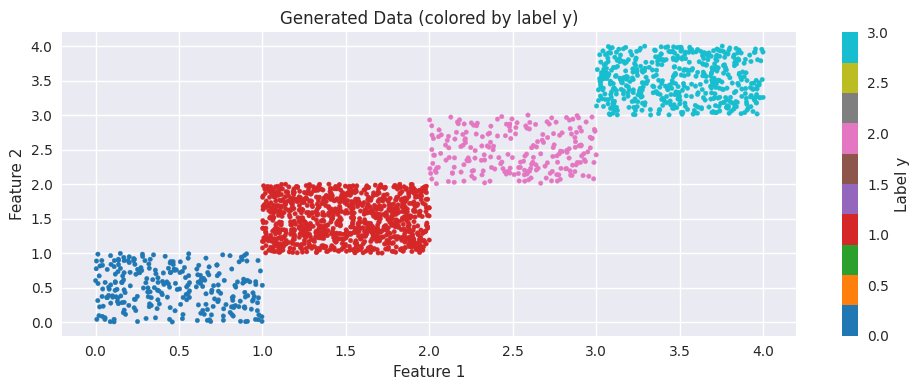

  Running scenario 'Common_Drift'
  Data shape: (2000, 3), Number of true drifts: 3
  Running D3
  Running DAWIDD
  Running ShapeDD


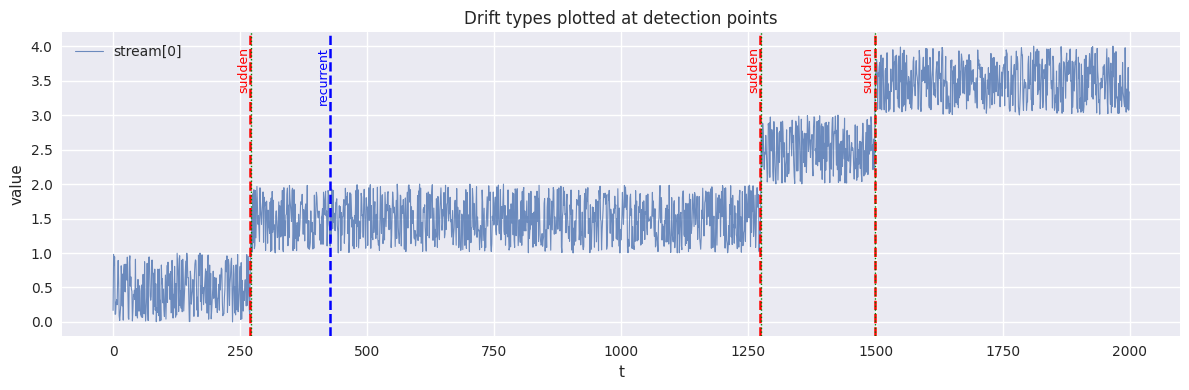

  Running ShapeDD_Improved


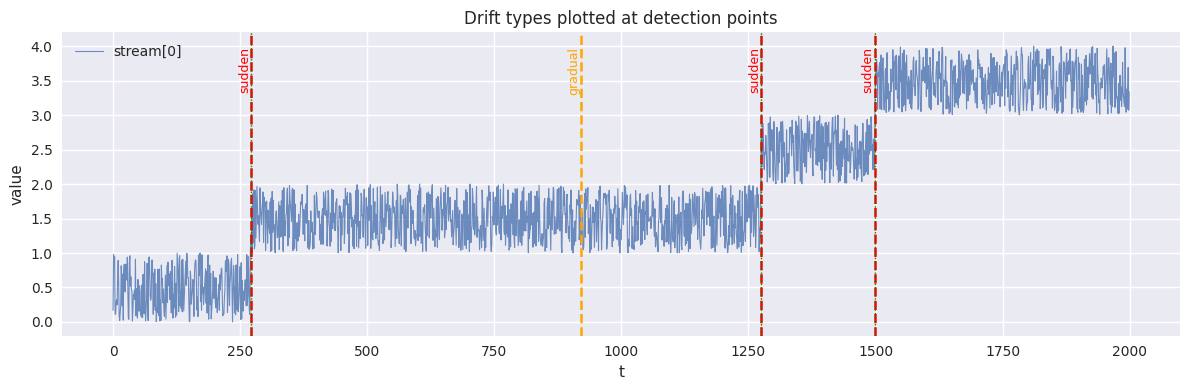

  Running ADWIN
  Running DDM
  Running EDDM
  Running HDDM_A
  Running HDDM_W
  Running FHDDM


In [15]:
for scenario in unified_scenarios:
    # Process the scenario from unified_scenarios
    scenario_name = scenario['name']
    params = scenario['params']

    label_config = scenario.get('label_config', {
        'angle_step_deg': 25.0,
        'bias': 1.255,
        'noise_rate': 0.05,
        'seed': RANDOM_SEED,
    })

    # Generate data for each scenario and make them global
    print(f"\nRunning scenario: {scenario_name}")
    print(f"Parameters: {params}")
    
    # Generate data using gen_random
    X, e = gen_random(**params)
    y = make_labels(X, e, **label_config)
    true_drifts = np.where(np.diff(e) != 0)[0] + 1
    stream_feature_names = [f'x_{idx}' for idx in range(X.shape[1])]

    plt.figure(figsize=(10, 4))
    if X.shape[1] == 1:
        plt.scatter(range(len(X)), X[:, 0], c=e, cmap='tab10', s=10)
        plt.xlabel('Sample Index')
        plt.ylabel('Feature Value')
    elif X.shape[1] == 2:
        plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    else:
        # For higher dimensions, plot first two features colored by y
        plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    plt.title('Generated Data (colored by label y)')
    plt.colorbar(label='Label y')
    plt.tight_layout()
    plt.show()

    # Store the results for this scenario
    results = []
    
    # Running this scenario
    print(f"  Running scenario '{scenario_name}'")
    print(f"  Data shape: {X.shape}, Number of true drifts: {len(true_drifts)}")
    
    # Evaluate window-based methods
    for method_name in window_methods:
        print(f"  Running {method_name}")
        # Use enhanced version with drift typing for ShapeDD
        if method_name in ['ShapeDD', 'ShapeDD_Improved']:
            result = evaluate_window_based_method_with_typing(
                X, e, true_drifts, method_name,
                enable_drift_typing=True,
                drift_type_config=DriftTypeConfig(
                    w_ref=200, 
                    w_basic=50,
                    sudden_len_thresh=150,
                )
            )
            # Plot drift types at detection points for ShapeDD
            if result['drift_types']:
                plot_stream_with_drift_types(X, result['detections'], result['drift_types'], true_e=e)
        else:
            result = evaluate_window_based_method(X, e, true_drifts, method_name)
        result['scenario'] = scenario_name
        results.append(result)
    
    # Evaluate streaming methods
    for method_name in streaming_methods:
        print(f"  Running {method_name}")
        result = evaluate_streaming_method(
            X,
            y,
            true_drifts,
            method_name,
            feature_names=stream_feature_names
        )
        result['scenario'] = scenario_name
        results.append(result)
    
    # Force garbage collection
    gc.collect()

    all_unified_results.extend(results)


In [16]:
# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)
unified_df


,method,paradigm,detections,drift_estimates,true_drift_scores,true_drifts_reference,estimate_correlation,runtime_per_batch_ms,runtime_per_instance_ms,total_runtime_s,...,scenario,drift_types,drift_typing_enabled,prequential_accuracy,moving_accuracy,accuracy_std,predictions,accuracies,signal_type_used,accuracy_window_size
0,D3,window,"[249, 549, 649, 799, 1049, 1149, 1499, 1649, 1...","[0.4496, 0.45262222222222226, 0.56124444444444...","[0.0, 0.0, 0.0, 0.31400447427293066, 0.5019239...","[271, 1275, 1499]",-0.909232,233.347460,4.433875,8.867750,...,Common_Drift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DAWIDD,window,"[299, 399, 1299, 1399, 1549]","[0.4284, 0.3152, 0.9408, 0.0, 0.0, 0.0, 0.6796...","[0.0, 0.0, 0.0, 0.31400447427293066, 0.5019239...","[271, 1275, 1499]",0.556823,90.355874,1.717615,3.435231,...,Common_Drift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShapeDD,window,"[270, 426, 1273, 1498]","[0.1296, 0.1296, 0.1296, 0.0, 0.0, 0.0, 0.0184...","[0.0, 0.0, 0.0, 0.31400447427293066, 0.5019239...","[271, 1275, 1499]",0.365835,9.741134,0.185262,0.370524,...,Common_Drift,"[{'drift_idx': 270, 'category': 'TCD', 'subcat...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ShapeDD_Improved,window,"[271, 920, 1275, 1498]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.31400447427293066, 0.5019239...","[271, 1275, 1499]",-0.576111,0.055215,0.125994,0.251987,...,Common_Drift,"[{'drift_idx': 271, 'category': 'TCD', 'subcat...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADWIN,streaming,[327],NaN,NaN,"[271, 1275, 1499]",NaN,NaN,3.361833,6.728752,...,Common_Drift,NaN,NaN,0.0,0.924444,0.264286,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",continuous,50.0
5,DDM,streaming,"[253, 302, 346]",NaN,NaN,"[271, 1275, 1499]",NaN,NaN,3.086131,6.177674,...,Common_Drift,NaN,NaN,0.0,0.938333,0.240549,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",binary,50.0
6,EDDM,streaming,"[300, 980, 1725]",NaN,NaN,"[271, 1275, 1499]",NaN,NaN,1.321903,2.646889,...,Common_Drift,NaN,NaN,0.0,0.939444,0.238513,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",binary,50.0
7,HDDM_A,streaming,[306],NaN,NaN,"[271, 1275, 1499]",NaN,NaN,3.330148,6.664885,...,Common_Drift,NaN,NaN,0.0,0.936111,0.244555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",continuous,50.0
8,HDDM_W,streaming,[280],NaN,NaN,"[271, 1275, 1499]",NaN,NaN,3.702276,7.409148,...,Common_Drift,NaN,NaN,0.0,0.936111,0.244555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",binary,50.0
9,FHDDM,streaming,[447],NaN,NaN,"[271, 1275, 1499]",NaN,NaN,2.700996,5.406018,...,Common_Drift,NaN,NaN,0.0,0.872222,0.333842,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",binary,50.0


In [17]:
# Print drift type summary for ShapeDD methods
print("\n" + "="*80)
print("DRIFT TYPE CLASSIFICATION SUMMARY")
print("="*80)
for result in all_unified_results:
    if result.get('drift_typing_enabled') and result.get('drift_types'):
        print(f"\n{result['scenario']} - {result['method']}:")
        for dt in result['drift_types']:
            print(f"  t={dt['drift_idx']}: {dt['category']}/{dt['subcategory']} (len={dt['drift_length']}, gap={dt['early_gap']:.3f})")



DRIFT TYPE CLASSIFICATION SUMMARY

Common_Drift - ShapeDD:
  t=270: TCD/sudden (len=130, gap=0.967)
  t=426: PCD/recurrent (len=230, gap=0.233)
  t=1273: TCD/sudden (len=130, gap=0.933)
  t=1498: TCD/sudden (len=130, gap=0.967)

Common_Drift - ShapeDD_Improved:
  t=271: TCD/sudden (len=110, gap=1.000)
  t=920: PCD/gradual (len=470, gap=0.213)
  t=1275: TCD/sudden (len=110, gap=1.000)
  t=1498: TCD/sudden (len=130, gap=0.967)


In [18]:
for scenario in unified_scenarios:
    scenario_name = scenario['name']
    scenario_df = unified_df[unified_df['scenario'] == scenario_name]
    print(f"\nScenario: {scenario_name}")
    print(scenario_df[['method', 'paradigm', 'tp', 'fp', 'fn', 'precision', 'recall', 'mttd', 'runtime_per_instance_ms']])
    
    # Extract true drifts from the first scenario (since we know the data generation parameters)
    scenario_params = scenario['params']  # Get the parameters used

    print(f"Extracted {len(true_drifts)} true drift points: {list(true_drifts)}")

    # Calculate F1-score
    unified_df['f1_score'] = 2 * unified_df['precision'] * unified_df['recall'] / (unified_df['precision'] + unified_df['recall'])
    unified_df['f1_score'] = unified_df['f1_score'].fillna(0)

    # Academic summary table
    summary_table = unified_df.groupby(['paradigm', 'method']).agg({
        'precision': 'mean',
        'recall': 'mean', 
        'f1_score': 'mean',
        'mttd': lambda x: np.mean(x[x != float('inf')]) if any(x != float('inf')) else float('inf'),
        'runtime_per_instance_ms': 'mean',
        'tp': 'sum',
        'fp': 'sum',
        'fn': 'sum'
    }).round(4)

    print("\nPerformance Metrics by Method")
    print(f"{'Method':<12} {'Paradigm':<10} {'Precision':<10} {'Recall':<8} {'F1':<8} {'MTTD':<8} {'Runtime(ms)':<12}")

    for (paradigm, method), row in summary_table.iterrows():
        mttd_str = f"{row['mttd']:.1f}" if row['mttd'] != float('inf') else "∞"
        print(f"{method:<12} {paradigm:<10} {row['precision']:<10.3f} {row['recall']:<8.3f} "
                f"{row['f1_score']:<8.3f} {mttd_str:<8} {row['runtime_per_instance_ms']:<12.4f}")



Scenario: Common_Drift
             method   paradigm  tp  fp  fn  precision    recall       mttd  \
0                D3     window   2   8   1   0.200000  0.666667 -11.000000   
1            DAWIDD     window   3   2   0   0.600000  1.000000  34.000000   
2           ShapeDD     window   3   1   0   0.750000  1.000000  -1.333333   
3  ShapeDD_Improved     window   3   1   0   0.750000  1.000000  -0.333333   
4             ADWIN  streaming   1   0   2   1.000000  0.333333  56.000000   
5               DDM  streaming   1   2   2   0.333333  0.333333 -18.000000   
6              EDDM  streaming   1   2   2   0.333333  0.333333  29.000000   
7            HDDM_A  streaming   1   0   2   1.000000  0.333333  35.000000   
8            HDDM_W  streaming   1   0   2   1.000000  0.333333   9.000000   
9             FHDDM  streaming   0   1   3   0.000000  0.000000        inf   

   runtime_per_instance_ms  
0                 4.433875  
1                 1.717615  
2                 0.185262  
3

In [19]:
# Define colors and markers
colors = {'window': '#2E86AB', 'streaming': '#A23B72'}  # Professional blue/burgundy
markers = {'window': 'o', 'streaming': 's'}


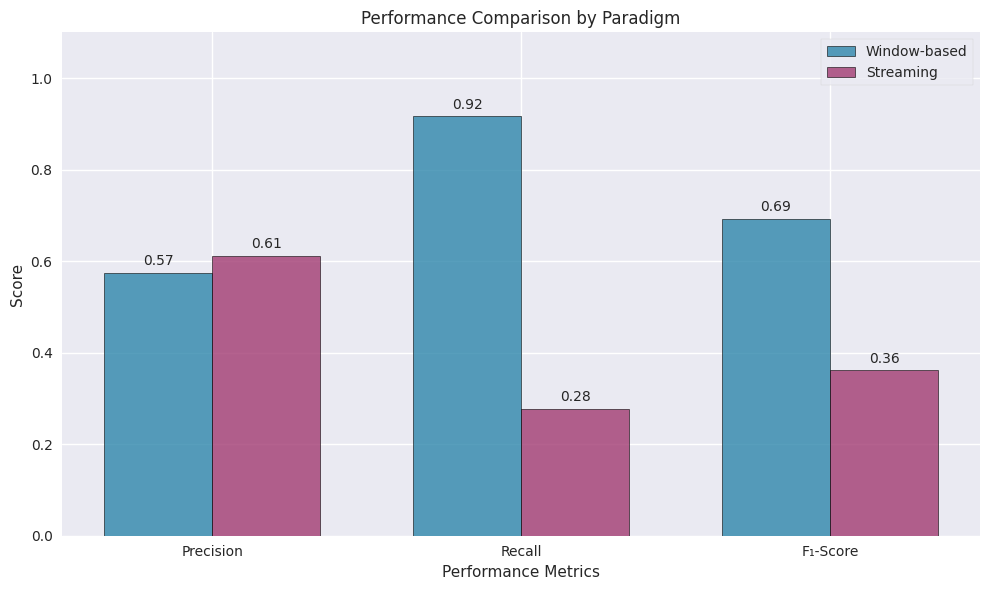

In [20]:
# Plot 1: Performance Comparison by Paradigm
plt.figure(figsize=(10, 6))
metric_keys = ['precision', 'recall', 'f1_score']
metric_labels = ['Precision', 'Recall', 'F₁-Score']

x = np.arange(len(metric_labels))
width = 0.35

window_means = [unified_df[unified_df['paradigm'] == 'window'][m].mean() for m in metric_keys]
streaming_means = [unified_df[unified_df['paradigm'] == 'streaming'][m].mean() for m in metric_keys]

bars1 = plt.bar(x - width/2, window_means, width, label='Window-based', 
                color=colors['window'], alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x + width/2, streaming_means, width, label='Streaming', 
                color=colors['streaming'], alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (w_val, s_val) in enumerate(zip(window_means, streaming_means)):
    plt.text(i - width/2, w_val + 0.01, f'{w_val:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, s_val + 0.01, f'{s_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison by Paradigm')
plt.xticks(x, metric_labels)
plt.legend(frameon=True, fancybox=False, shadow=False)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


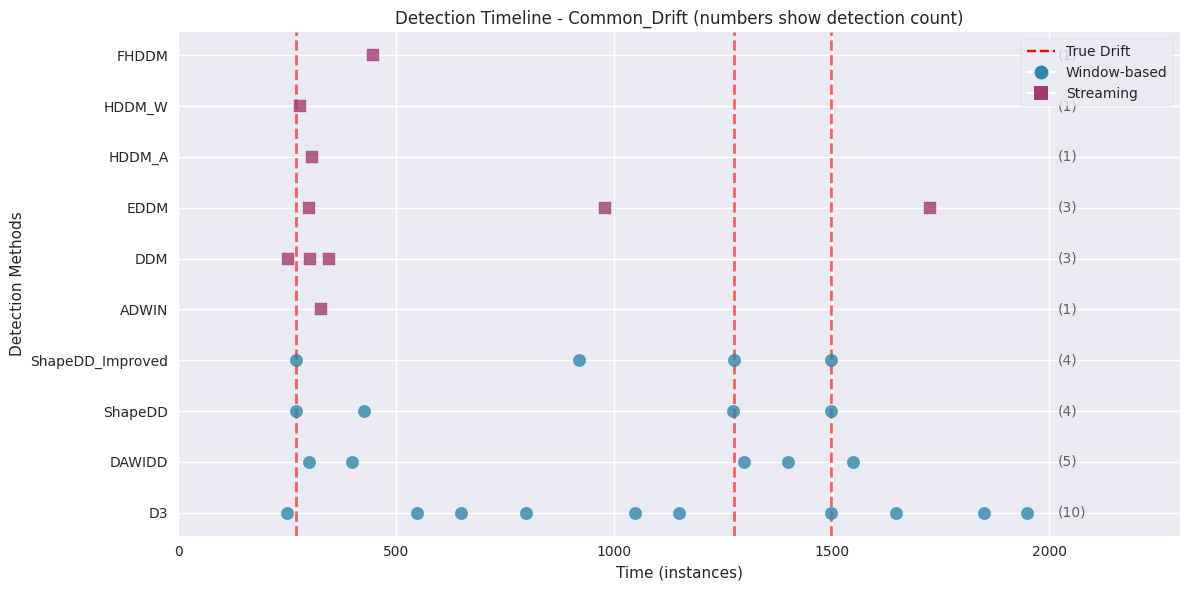

In [21]:
# Plot 2: Detection Timeline Analysis (Split by Scenario)
scenarios = unified_df['scenario'].unique()
n_scenarios = len(scenarios)

fig, axes = plt.subplots(n_scenarios, 1, figsize=(12, 6 * n_scenarios))
if n_scenarios == 1:
    axes = [axes]  # Make it iterable for single scenario

for scenario_idx, scenario_name in enumerate(scenarios):
    ax = axes[scenario_idx]
    scenario_data = unified_df[unified_df['scenario'] == scenario_name]
    
    # Get scenario parameters to determine data length
    scenario_params = next(s['params'] for s in unified_scenarios if s['name'] == scenario_name)
    data_length = scenario_params['length']
    
    # Get true drifts for this scenario
    if scenario_name != 'No_Drift':
        # For Common_Drift scenario, use the true_drifts from the data
        # Get true drifts from the first row of this scenario (they should be the same for all methods)
        first_row = scenario_data.iloc[0]
        scenario_true_drifts = first_row['true_drifts_reference'] if len(first_row['true_drifts_reference']) > 0 else []
    else:
        # For No_Drift scenario, there should be no true drifts
        scenario_true_drifts = []
    
    # Plot true drifts as vertical lines
    for drift in scenario_true_drifts:
        ax.axvline(x=drift, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=1)
    
    # Create method mapping for y-positions
    method_names = []
    y_positions = []
    y_pos = 0
    
    # Process window methods first, then streaming
    for paradigm in ['window', 'streaming']:
        paradigm_data = scenario_data[scenario_data['paradigm'] == paradigm]
        for _, row in paradigm_data.iterrows():
            method_name = f"{row['method']}"
            method_names.append(method_name)
            y_positions.append(y_pos)
            
            detections = row['detections']
            if len(detections) > 0:
                ax.scatter(detections, [y_pos] * len(detections), 
                          c=colors[paradigm], marker=markers[paradigm], 
                          s=80, alpha=0.8, zorder=2)
            
            # Add detection count annotation
            ax.text(data_length * 1.01, y_pos, f"({len(detections)})", 
                   va='center', fontsize=10, alpha=0.7)
            
            y_pos += 1
    
    ax.set_xlabel('Time (instances)')
    ax.set_ylabel('Detection Methods')
    ax.set_title(f'Detection Timeline - {scenario_name} (numbers show detection count)')
    ax.set_xlim(0, data_length * 1.15)
    ax.set_yticks(range(len(method_names)))
    ax.set_yticklabels(method_names, fontsize=10)
    
    # Create custom legend only for the first subplot
    if scenario_idx == 0:
        from matplotlib.lines import Line2D
        legend_elements = [Line2D([0], [0], color='red', linestyle='--', label='True Drift'),
                          Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['window'], 
                                markersize=10, label='Window-based'),
                          Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['streaming'], 
                                markersize=10, label='Streaming')]
        ax.legend(handles=legend_elements, frameon=True, loc='upper right')

plt.tight_layout()
plt.show()


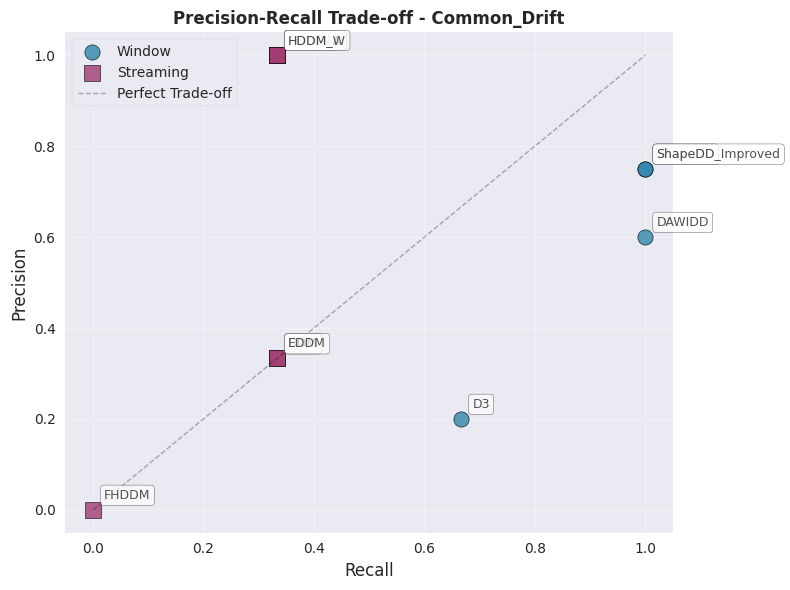

In [22]:
# Plot 3: Precision-Recall Trade-off Analysis (Split by Scenario)
scenarios = unified_df['scenario'].unique()
n_scenarios = len(scenarios)

fig, axes = plt.subplots(1, n_scenarios, figsize=(8 * n_scenarios, 6))
if n_scenarios == 1:
    axes = [axes]  # Make it iterable for single scenario

for scenario_idx, scenario_name in enumerate(scenarios):
    ax = axes[scenario_idx]
    scenario_data = unified_df[unified_df['scenario'] == scenario_name]
    
    # Filter out rows with NaN precision/recall values
    scenario_data = scenario_data.dropna(subset=['precision', 'recall'])
    
    if len(scenario_data) == 0:
        ax.text(0.5, 0.5, f'No valid data\nfor {scenario_name}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Precision-Recall Trade-off - {scenario_name}')
        continue
    
    for paradigm in ['window', 'streaming']:
        paradigm_data = scenario_data[scenario_data['paradigm'] == paradigm]
        if len(paradigm_data) > 0:
            scatter = ax.scatter(paradigm_data['recall'], paradigm_data['precision'], 
                                c=colors[paradigm], marker=markers[paradigm], s=120, 
                                alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
            
            # Add method labels
            for _, row in paradigm_data.iterrows():
                ax.annotate(row['method'], (row['recall'], row['precision']), 
                           xytext=(8, 8), textcoords='offset points', fontsize=9, alpha=0.8,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # Add diagonal line for reference
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1, label='Perfect Trade-off')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'Precision-Recall Trade-off - {scenario_name}', fontsize=12, fontweight='bold')
    ax.legend(frameon=True, fontsize=10)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


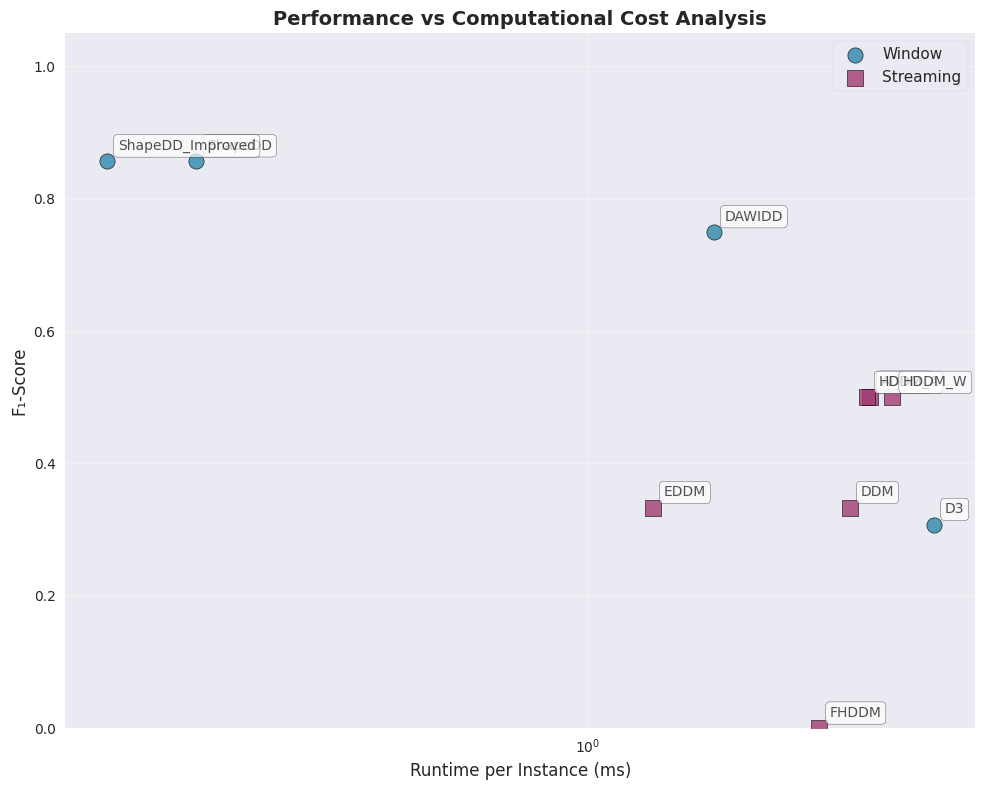

In [23]:
# Plot 4: Performance vs Computational Cost Analysis
plt.figure(figsize=(10, 8))

for paradigm in ['window', 'streaming']:
    data = unified_df[unified_df['paradigm'] == paradigm]
    scatter = plt.scatter(data['runtime_per_instance_ms'], data['f1_score'], 
                        c=colors[paradigm], marker=markers[paradigm], s=120, 
                        alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    # Add method labels
    for _, row in data.iterrows():
        plt.annotate(row['method'], (row['runtime_per_instance_ms'], row['f1_score']), 
                    xytext=(8, 8), textcoords='offset points', fontsize=10, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.xlabel('Runtime per Instance (ms)', fontsize=12)
plt.ylabel('F₁-Score', fontsize=12)
plt.title('Performance vs Computational Cost Analysis', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.legend(frameon=True, fontsize=11)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


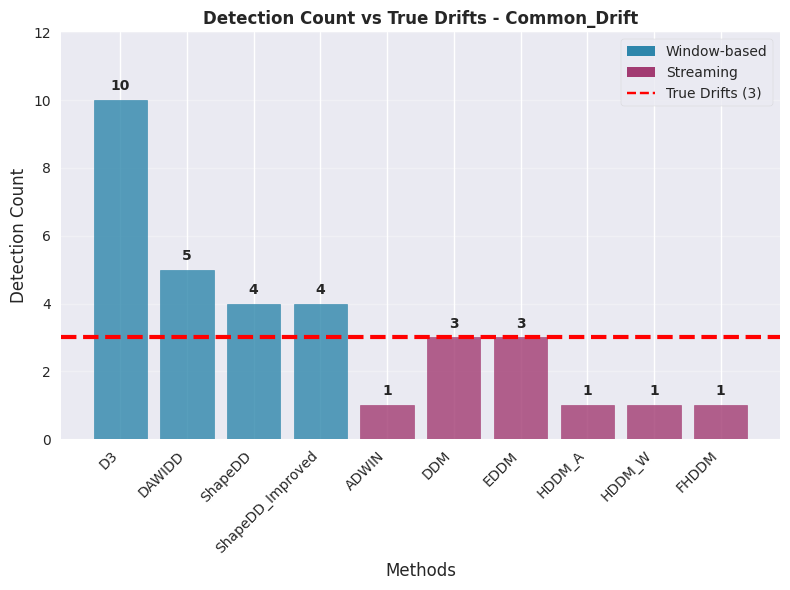

In [24]:
# Plot 5: Detection Count vs True Drifts Analysis (Split by Scenario)
scenarios = unified_df['scenario'].unique()
n_scenarios = len(scenarios)

fig, axes = plt.subplots(1, n_scenarios, figsize=(8 * n_scenarios, 6))
if n_scenarios == 1:
    axes = [axes]  # Make it iterable for single scenario

for scenario_idx, scenario_name in enumerate(scenarios):
    ax = axes[scenario_idx]
    scenario_data = unified_df[unified_df['scenario'] == scenario_name]
    
    # Get true drift count for this scenario
    if len(scenario_data) > 0:
        # Get true drifts from the first row of this scenario (they should be the same for all methods)
        first_row = scenario_data.iloc[0]
        scenario_true_drifts = first_row['true_drifts_reference'] if len(first_row['true_drifts_reference']) > 0 else []
        true_drift_count = len(scenario_true_drifts)
    else:
        true_drift_count = 0
    
    methods = scenario_data['method'].tolist()
    detection_counts = [len(row['detections']) for _, row in scenario_data.iterrows()]
    
    bars = ax.bar(range(len(methods)), detection_counts, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add horizontal line for true drifts (only if there are true drifts)
    if true_drift_count > 0:
        ax.axhline(y=true_drift_count, color='red', linestyle='--', linewidth=3,
                  label=f'True Drifts ({true_drift_count})')
    
    # Color bars by paradigm
    for i, (_, row) in enumerate(scenario_data.iterrows()):
        color = colors[row['paradigm']]
        bars[i].set_color(color)
        # Add count labels on bars
        if detection_counts[i] > 0:
            ax.text(i, detection_counts[i] + max(max(detection_counts), true_drift_count) * 0.02, 
                   str(detection_counts[i]), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Methods', fontsize=12)
    ax.set_ylabel('Detection Count', fontsize=12)
    ax.set_title(f'Detection Count vs True Drifts - {scenario_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, rotation=45, ha='right')
    
    # Create custom legend for paradigms and true drifts
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                       plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming')]
    
    if true_drift_count > 0:
        legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', 
                                        label=f'True Drifts ({true_drift_count})'))
    
    ax.legend(handles=legend_elements, frameon=True, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set y-limit to accommodate all bars and legend
    max_y = max(max(detection_counts) if detection_counts else 0, true_drift_count)
    ax.set_ylim(0, max_y * 1.2)

plt.tight_layout()
plt.show()


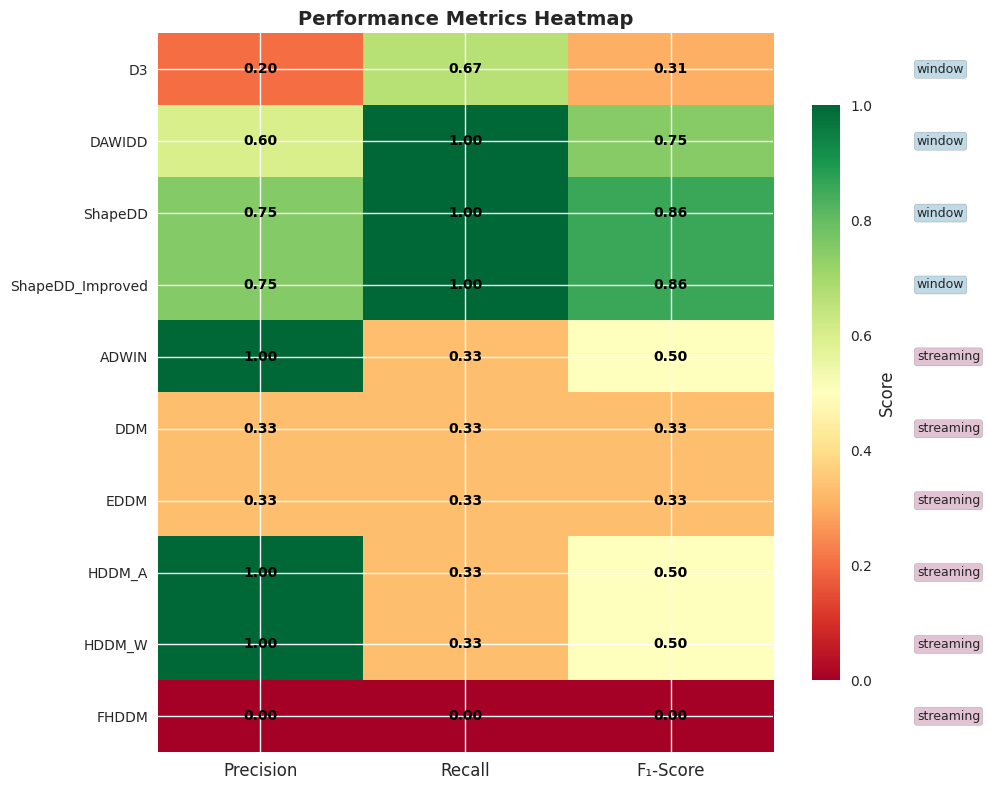

In [25]:
# Plot 6: Performance Metrics Heatmap
plt.figure(figsize=(10, 8))

metrics_data = unified_df[['precision', 'recall', 'f1_score']].values
methods = unified_df['method'].tolist()

im = plt.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.xticks(range(3), ['Precision', 'Recall', 'F₁-Score'], fontsize=12)
plt.yticks(range(len(methods)), methods, fontsize=10)
plt.title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Score', fontsize=12)

# Add text annotations
for i in range(len(methods)):
    for j in range(3):
        text = plt.text(j, i, f'{metrics_data[i, j]:.2f}',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)

# Add paradigm indicators on the right
for i, (_, row) in enumerate(unified_df.iterrows()):
    paradigm = row['paradigm']
    plt.text(3.2, i, paradigm, ha='left', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[paradigm], alpha=0.3))

plt.tight_layout()
plt.show()


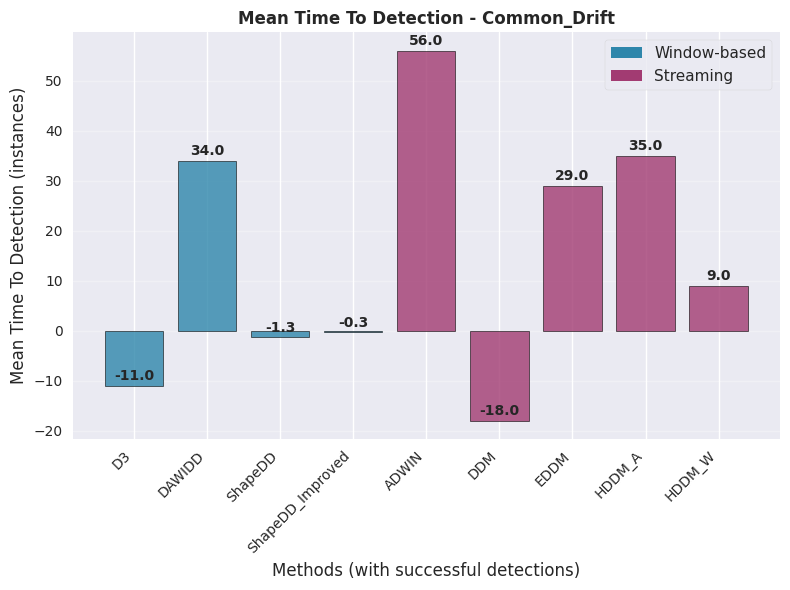

In [26]:
# Plot 7: Mean Time To Detection Analysis (Split by Scenario)
scenarios = unified_df['scenario'].unique()
n_scenarios = len(scenarios)

fig, axes = plt.subplots(1, n_scenarios, figsize=(8 * n_scenarios, 6))
if n_scenarios == 1:
    axes = [axes]  # Make it iterable for single scenario

for scenario_idx, scenario_name in enumerate(scenarios):
    ax = axes[scenario_idx]
    scenario_data = unified_df[unified_df['scenario'] == scenario_name]
    
    # Filter out rows with infinite MTTD values
    valid_mttd_data = scenario_data[scenario_data['mttd'].notna() & (scenario_data['mttd'] != float('inf'))]
    
    if len(valid_mttd_data) == 0:
        ax.text(0.5, 0.5, f'No successful detections\nwith finite MTTD\nin {scenario_name}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Mean Time To Detection - {scenario_name}', fontsize=12, fontweight='bold')
        continue
    
    mttd_values = valid_mttd_data['mttd'].tolist()
    method_labels = valid_mttd_data['method'].tolist()
    colors_list = [colors[row['paradigm']] for _, row in valid_mttd_data.iterrows()]
    
    bars = ax.bar(range(len(mttd_values)), mttd_values, color=colors_list, alpha=0.8, 
                  edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for i, val in enumerate(mttd_values):
        ax.text(i, val + max(mttd_values) * 0.01, f'{val:.1f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Methods (with successful detections)', fontsize=12)
    ax.set_ylabel('Mean Time To Detection (instances)', fontsize=12)
    ax.set_title(f'Mean Time To Detection - {scenario_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(method_labels)))
    ax.set_xticklabels(method_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Create custom legend for paradigms (only for the first subplot)
    if scenario_idx == 0:
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                          plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming')]
        ax.legend(handles=legend_elements, frameon=True, fontsize=11)

plt.tight_layout()
plt.show()


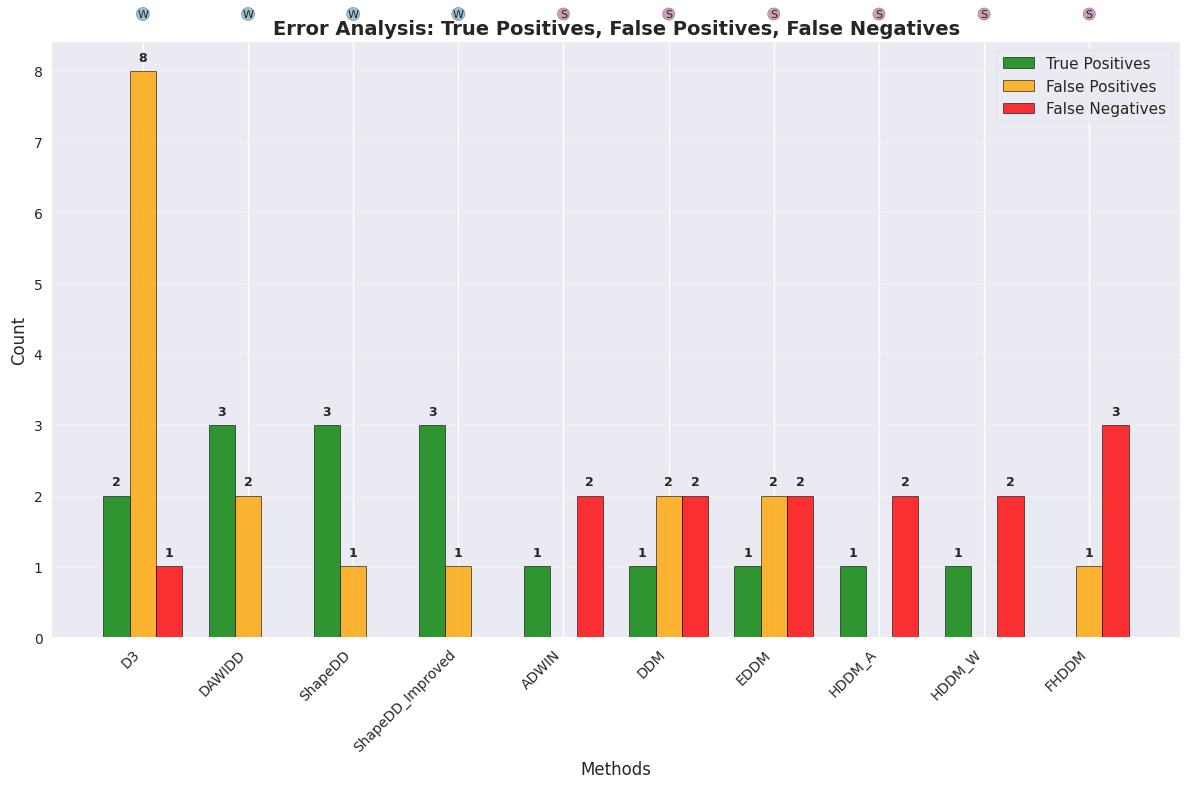

In [27]:
# Plot 8: Error Analysis (TP/FP/FN)
plt.figure(figsize=(12, 8))

methods = unified_df['method'].tolist()
tp_values = unified_df['tp'].tolist()
fp_values = unified_df['fp'].tolist()
fn_values = unified_df['fn'].tolist()

x = np.arange(len(methods))
width = 0.25

bars1 = plt.bar(x - width, tp_values, width, label='True Positives', 
                color='green', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x, fp_values, width, label='False Positives', 
                color='orange', alpha=0.8, edgecolor='black', linewidth=0.5)
bars3 = plt.bar(x + width, fn_values, width, label='False Negatives', 
                color='red', alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (tp, fp, fn) in enumerate(zip(tp_values, fp_values, fn_values)):
    if tp > 0:
        plt.text(i - width, tp + 0.1, str(tp), ha='center', va='bottom', fontsize=9, fontweight='bold')
    if fp > 0:
        plt.text(i, fp + 0.1, str(fp), ha='center', va='bottom', fontsize=9, fontweight='bold')
    if fn > 0:
        plt.text(i + width, fn + 0.1, str(fn), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Methods', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Error Analysis: True Positives, False Positives, False Negatives', fontsize=14, fontweight='bold')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend(frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add paradigm indicators
for i, (_, row) in enumerate(unified_df.iterrows()):
    paradigm = row['paradigm']
    plt.text(i, max(max(tp_values), max(fp_values), max(fn_values)) * 1.1, 
             paradigm[0].upper(), ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='circle,pad=0.1', facecolor=colors[paradigm], alpha=0.5))

plt.tight_layout()
plt.show()


In [28]:
# RUNME
# Reset matplotlib parameters to default
plt.rcParams.update(plt.rcParamsDefault)  


## Different drift scenarios

In [29]:
X, e = X_gradual, drift_indicator = gen_gradual_drift_improved(
    number=1, dims=2, intens=1, dist="unif", length=1000,
    drift_type="sigmoid", transition_length=200
)


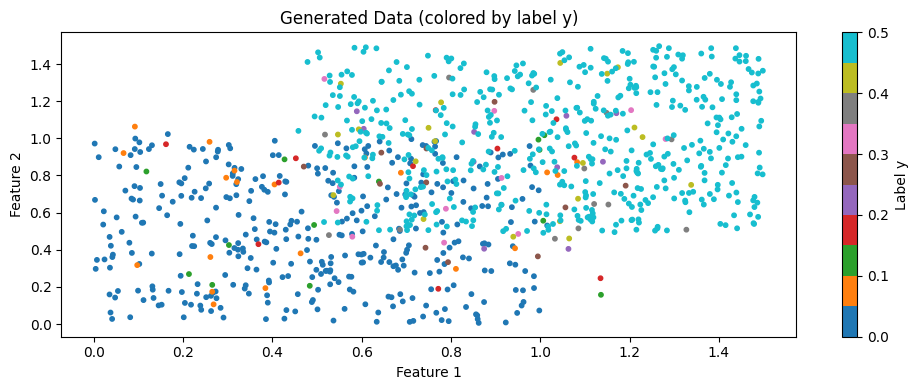

In [30]:
plt.figure(figsize=(10, 4))
if X.shape[1] == 1:
    plt.scatter(range(len(X)), X[:, 0], c=e, cmap='tab10', s=10)
    plt.xlabel('Sample Index')
    plt.ylabel('Feature Value')
elif X.shape[1] == 2:
    plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
else:
    # For higher dimensions, plot first two features colored by y
    plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
plt.title('Generated Data (colored by label y)')
plt.colorbar(label='Label y')
plt.tight_layout()
plt.show()


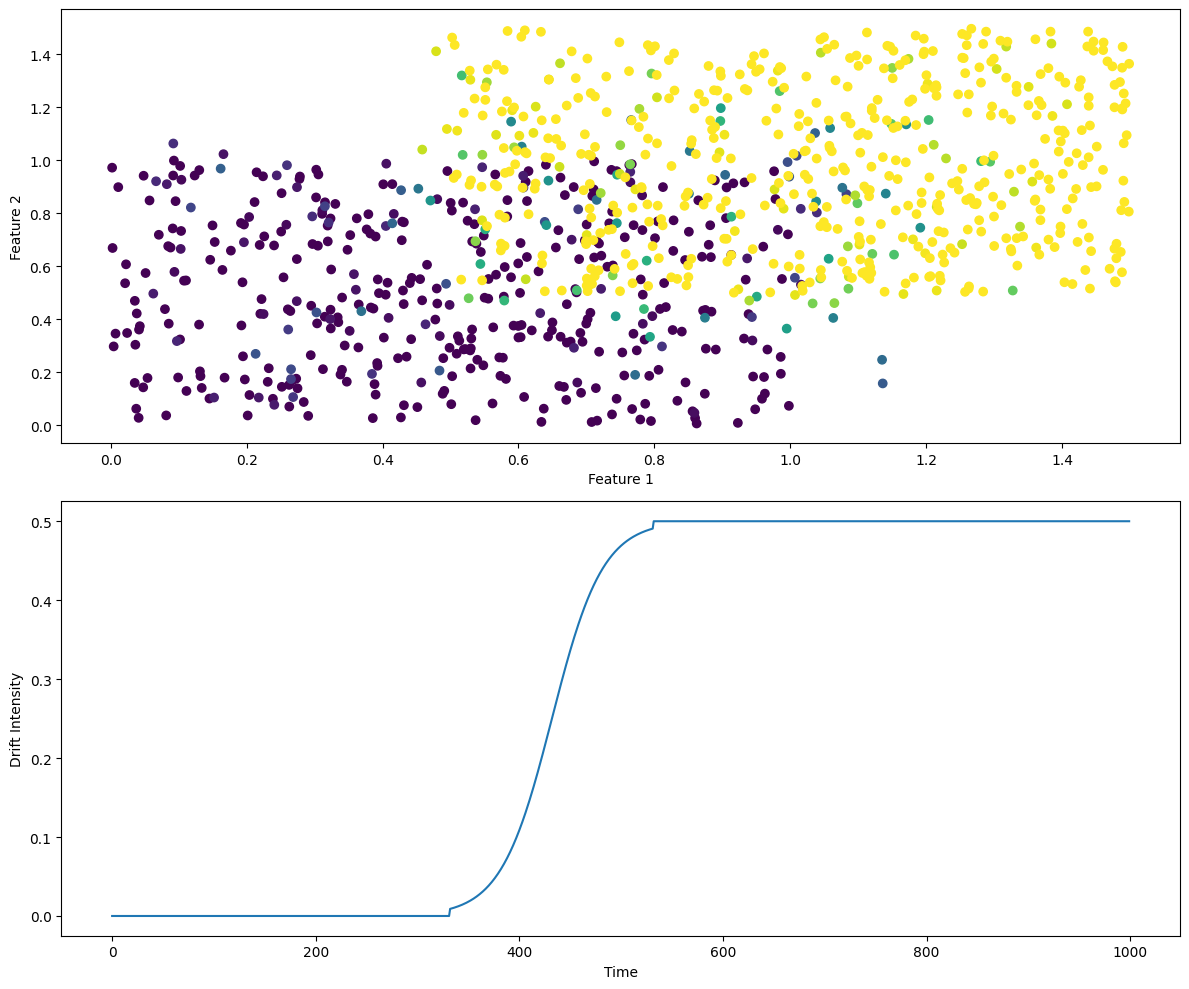

In [31]:
# Create comparison plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot gradual drift
axes[0].scatter(X_gradual[:,0], X_gradual[:,1], c=drift_indicator, cmap='viridis')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].plot(drift_indicator)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Drift Intensity')

plt.tight_layout()
plt.show()


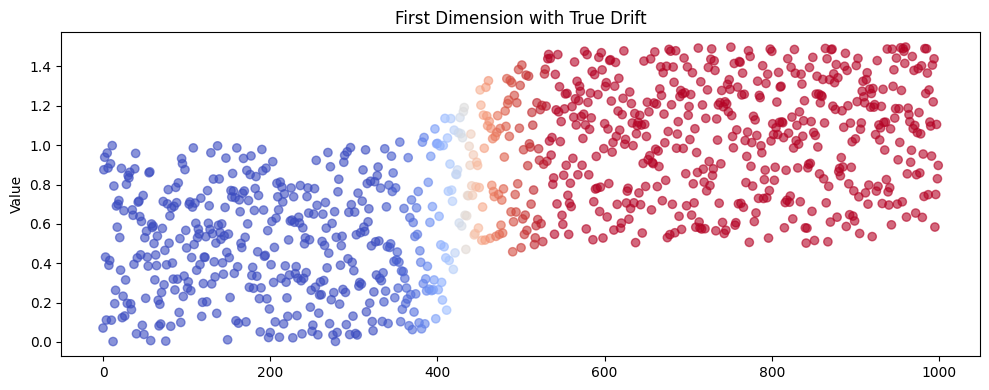

In [32]:
plt.figure(figsize=(10, 4))

plt.scatter(range(len(X)), X[:, 0], c=e if e is not None else 'blue', 
            cmap='coolwarm', alpha=0.6)
plt.title('First Dimension with True Drift')
plt.ylabel('Value')

    
plt.tight_layout()
plt.show()


In [33]:
y = make_labels(X, e, **label_config)
# Calculate true drift positions from the drift indicator
true_drifts = np.where(np.diff(e) != 0)[0] + 1
stream_feature_names = [f'x_{idx}' for idx in range(X.shape[1])]


In [34]:
def run_unified_experiment():
    print(f"  Data: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  True drifts at: {list(true_drifts)}")
    
    results = []
    
    # # Evaluate window-based methods
    # for method_name in window_methods:
    #     print(f"  Running {method_name}")
    #     result = evaluate_window_based_method(X, e, true_drifts, method_name)
    #     result['scenario'] = scenario_name
    #     results.append(result)
    
    # Evaluate window-based methods
    for method_name in window_methods:
        print(f"  Running {method_name}")
        # Use enhanced version with drift typing for ShapeDD
        if method_name in ['ShapeDD', 'ShapeDD_Improved']:
            result = evaluate_window_based_method_with_typing(
                X, e, true_drifts, method_name,
                enable_drift_typing=True,
                drift_type_config=DriftTypeConfig(
                    w_ref=200, 
                    w_basic=50,
                    sudden_len_thresh=150,
                )
            )
            # Plot drift types at detection points for ShapeDD
            if result['drift_types']:
                plot_stream_with_drift_types(X, result['detections'], result['drift_types'], true_e=e)
        else:
            result = evaluate_window_based_method(X, e, true_drifts, method_name)
        result['scenario'] = scenario_name
        results.append(result)

    # # Evaluate streaming methods
    # for method_name in streaming_methods:
    #     print(f"  Running {method_name}")
    #     result = evaluate_streaming_method(
    #         X,
    #         y,
    #         true_drifts,
    #         method_name,
    #         feature_names=stream_feature_names
    #     )
    #     result['scenario'] = scenario_name
    #     results.append(result)
    
    # Force garbage collection
    gc.collect()
    
    return results


  Data: 1000 samples, 2 features
  True drifts at: [np.int64(332), np.int64(333), np.int64(334), np.int64(335), np.int64(336), np.int64(337), np.int64(338), np.int64(339), np.int64(340), np.int64(341), np.int64(342), np.int64(343), np.int64(344), np.int64(345), np.int64(346), np.int64(347), np.int64(348), np.int64(349), np.int64(350), np.int64(351), np.int64(352), np.int64(353), np.int64(354), np.int64(355), np.int64(356), np.int64(357), np.int64(358), np.int64(359), np.int64(360), np.int64(361), np.int64(362), np.int64(363), np.int64(364), np.int64(365), np.int64(366), np.int64(367), np.int64(368), np.int64(369), np.int64(370), np.int64(371), np.int64(372), np.int64(373), np.int64(374), np.int64(375), np.int64(376), np.int64(377), np.int64(378), np.int64(379), np.int64(380), np.int64(381), np.int64(382), np.int64(383), np.int64(384), np.int64(385), np.int64(386), np.int64(387), np.int64(388), np.int64(389), np.int64(390), np.int64(391), np.int64(392), np.int64(393), np.int64(394), np.

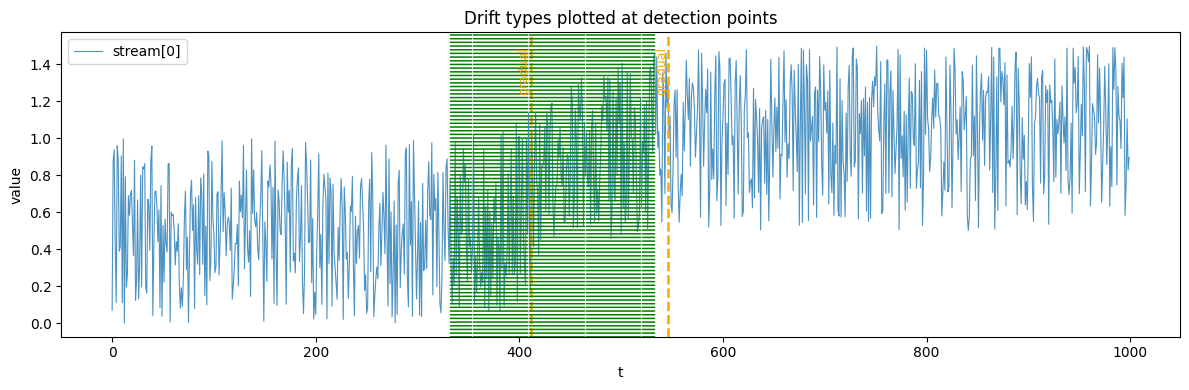

  Running ShapeDD_Improved


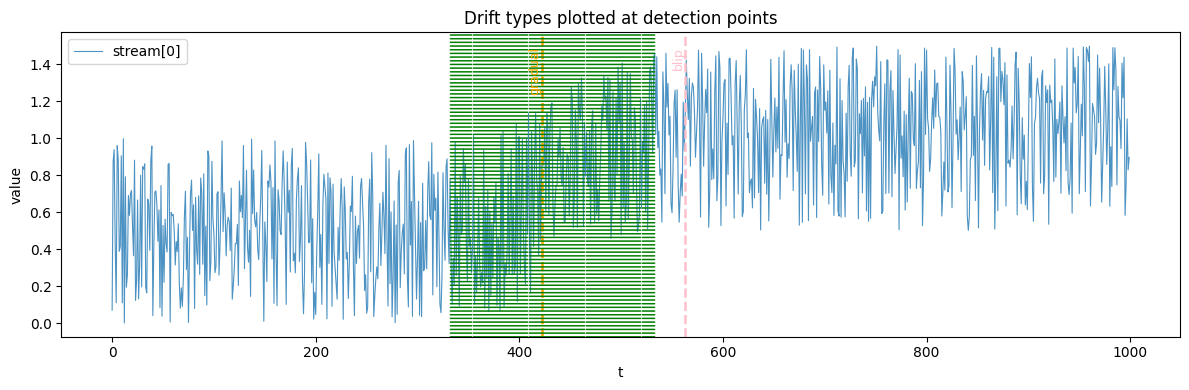

In [35]:
# Run the unified_experiment

all_unified_results = []

scenario_results = run_unified_experiment()
all_unified_results.extend(scenario_results)


In [36]:
# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)


In [37]:
unified_df


,method,paradigm,detections,drift_estimates,true_drift_scores,true_drifts_reference,estimate_correlation,runtime_per_batch_ms,runtime_per_instance_ms,total_runtime_s,...,f1_score,detection_delays,acceptable_delta,allow_early_detection,matched_pairs,total_true_drifts,total_detections,scenario,drift_types,drift_typing_enabled
0,D3,window,"[249, 349, 749, 849, 949]","[0.49226666666666663, 0.4337777777777778, 0.50...","[0.0, 0.0, 0.0, 0.0, 0.22630872483221476, 0.70...","[332, 333, 334, 335, 336, 337, 338, 339, 340, ...",-0.716971,260.770806,4.694331,4.694331,...,0.009709,[17.0],100,True,"[(332, 349, 17)]",201,5,Common_Drift,NaN,NaN
1,DAWIDD,window,"[299, 399, 499]","[0.6204, 0.2748, 0.452, 0.0452, 0.5796, 0.012,...","[0.0, 0.0, 0.0, 0.0, 0.22630872483221476, 0.70...","[332, 333, 334, 335, 336, 337, 338, 339, 340, ...",0.711029,15.646641,0.282232,0.282232,...,0.029412,"[49.0, 49.0, -33.0]",100,True,"[(350, 399, 49), (450, 499, 49), (332, 299, -33)]",201,3,Common_Drift,NaN,NaN
2,ShapeDD,window,"[411, 546]","[0.2504, 0.2504, 0.056, 0.056, 0.056, 1.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.22630872483221476, 0.70...","[332, 333, 334, 335, 336, 337, 338, 339, 340, ...",0.143156,4.412541,0.079648,0.079648,...,0.019704,"[79.0, 84.0]",100,True,"[(332, 411, 79), (462, 546, 84)]",201,2,Common_Drift,"[{'drift_idx': 411, 'category': 'PCD', 'subcat...",True
3,ShapeDD_Improved,window,"[422, 563]","[0.0788, 0.0788, 0.0788, 0.1004, 0.1004, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.22630872483221476, 0.70...","[332, 333, 334, 335, 336, 337, 338, 339, 340, ...",-0.162190,0.041661,0.173808,0.173808,...,0.019704,"[90.0, 90.0]",100,True,"[(332, 422, 90), (473, 563, 90)]",201,2,Common_Drift,"[{'drift_idx': 422, 'category': 'PCD', 'subcat...",True


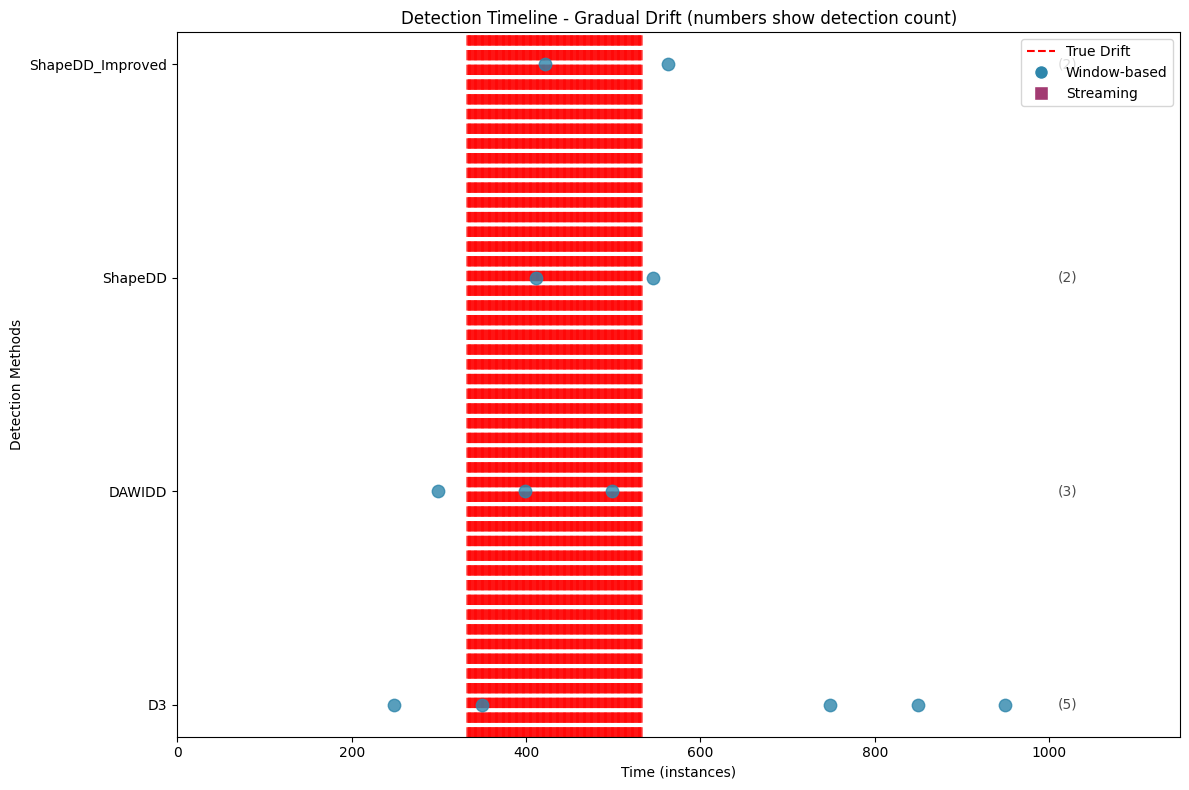

In [38]:
# Plot 2: Detection Timeline Analysis  
plt.figure(figsize=(12, 8))

# Plot true drifts as vertical lines
for drift in true_drifts:
    plt.axvline(x=drift, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=1)

# Create method mapping for y-positions with clear labels
method_names = []
y_positions = []
y_pos = 0

# Process window methods first, then streaming
for paradigm in ['window', 'streaming']:
    paradigm_data = unified_df[unified_df['paradigm'] == paradigm]
    for _, row in paradigm_data.iterrows():
        method_name = f"{row['method']}"
        method_names.append(method_name)
        y_positions.append(y_pos)
        
        detections = row['detections']
        if len(detections) > 0:
            plt.scatter(detections, [y_pos] * len(detections), 
                        c=colors[paradigm], marker=markers[paradigm], 
                        s=80, alpha=0.8, zorder=2, 
                        label=f"{paradigm.title()}" if method_name == paradigm_data.iloc[0]['method'] else "")
        
        # Add detection count annotation
        if len(detections) > 0:
            plt.text(len(X) * 1.01, y_pos, f"({len(detections)})", 
                    va='center', fontsize=10, alpha=0.7)
        
        y_pos += 1

plt.xlabel('Time (instances)')
plt.ylabel('Detection Methods')
plt.title('Detection Timeline - Gradual Drift (numbers show detection count)')
plt.xlim(0, len(X) * 1.15)
plt.yticks(range(len(method_names)), method_names, fontsize=10)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linestyle='--', label='True Drift'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['window'], 
                        markersize=10, label='Window-based'),
                    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['streaming'], 
                        markersize=10, label='Streaming')]
plt.legend(handles=legend_elements, frameon=True, loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# RUNME


# Empirical Evaluation on Real-World Datasets

This section evaluates the comparative performance of concept drift detection methods on real-world benchmark datasets from the River library. Unlike controlled synthetic experiments, real-world datasets present inherent challenges including unknown drift timing, varying signal-to-noise ratios, and complex distribution shifts. The evaluation methodology employs prequential learning (test-then-train) to assess detector responsiveness in realistic streaming scenarios.

## Methodology

The evaluation framework integrates standard benchmark datasets (Elec2, AirlinePassengers) directly from the River streaming machine learning library. For datasets without annotated drift locations, detection performance is assessed through computational efficiency metrics, detection frequency patterns, and prequential accuracy maintenance. The window-based methods operate on batch segments while streaming methods process instances sequentially, enabling direct paradigm comparison under identical data conditions.

In [ ]:
# Simple Dataset Loading Utilities for Real-World Benchmarks
from river import datasets
import pandas as pd
import numpy as np


In [ ]:
datasets.Elec2()


In [ ]:
datasets.AirlinePassengers()


In [ ]:
df_elec2 = pd.read_csv('../datasets/electricity.csv')
df_elec2


In [ ]:
df_airline = pd.read_csv('../datasets/airline-passengers.csv')
df_airline


In [ ]:
import matplotlib.pyplot as plt

df_airline_copy = df_airline.copy()

# Convert month to datetime for better plotting
df_airline_copy['month'] = pd.to_datetime(df_airline['month'])
df_airline_copy['passengers'] = df_airline['passengers']

# Plot the AirlinePassengers dataset
plt.figure(figsize=(12, 6))

plt.plot(df_airline['month'], df_airline['passengers'], 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Airline Passengers Time Series (1949-1960)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

# Display basic statistics
print(f"Passenger count range: {df_airline['passengers'].min()} - {df_airline['passengers'].max()}")
print(f"Mean passengers: {df_airline['passengers'].mean():.1f}")
print(f"Standard deviation: {df_airline['passengers'].std():.1f}")
print(f"Time period: {df_airline['month'].min()} to {df_airline['month'].max()}")


In [ ]:
# Load and prepare Elec2 data for plotting
df_elec2_copy = df_elec2.copy()

# Create a figure with subplots for better visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Price over time
ax1.plot(range(len(df_elec2)), df_elec2_copy['nswprice'], 'b-', linewidth=1, alpha=0.7, label='NSW Price')
ax1.plot(range(len(df_elec2)), df_elec2_copy['vicprice'], 'r-', linewidth=1, alpha=0.7, label='VIC Price')
ax1.set_xlabel('Time (instances)')
ax1.set_ylabel('Price')
ax1.set_title('Electricity Prices Over Time (NSW vs VIC)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Price increase indicator (binary target)

# Convert the binary class to integer for plotting
df_elec2_copy['class'] = df_elec2_copy['class'].map({'UP': 1, 'DOWN': 0})

price_increase = df_elec2_copy['class'].astype(int)
ax2.plot(range(len(df_elec2_copy)), price_increase, 'g-', linewidth=1, alpha=0.8)
ax2.fill_between(range(len(df_elec2_copy)), price_increase, alpha=0.3, color='green')
ax2.set_xlabel('Time (instances)')
ax2.set_ylabel('Price Increase (Binary)')
ax2.set_title('Price Increase Indicator Over Time')
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display basic statistics
print(f"Dataset shape: {df_elec2_copy.shape}")
print(f"NSW price range: {df_elec2_copy['nswprice'].min():.3f} - {df_elec2['nswprice'].max():.3f}")
print(f"VIC price range: {df_elec2_copy['vicprice'].min():.3f} - {df_elec2['vicprice'].max():.3f}")
print(f"Price increase rate: {df_elec2_copy['class'].mean():.3f}")
print(f"Class distribution: {df_elec2_copy['class'].value_counts().to_dict()}")


In [ ]:
df_elec2_copy


In [ ]:
# Plot a smaller subset of Elec2 data for better visualization
sample_size = 1000  # Use first 1000 instances for clearer visualization
df_elec2_sample = df_elec2_copy.head(sample_size).copy()

# Create a figure with subplots for better visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Price over time (sample)
ax1.plot(range(len(df_elec2_sample)), df_elec2_sample['nswprice'], 'b-', linewidth=1, alpha=0.8, label='NSW Price')
ax1.plot(range(len(df_elec2_sample)), df_elec2_sample['vicprice'], 'r-', linewidth=1, alpha=0.8, label='VIC Price')
ax1.set_xlabel('Time (instances)')
ax1.set_ylabel('Price')
ax1.set_title(f'Electricity Prices Over Time - First {sample_size} Instances (NSW vs VIC)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Price increase indicator (binary target) - sample
price_increase_sample = df_elec2_sample['class']
ax2.plot(range(len(df_elec2_sample)), price_increase_sample, 'g-', linewidth=1, alpha=0.9)
ax2.fill_between(range(len(df_elec2_sample)), price_increase_sample, alpha=0.4, color='green')
ax2.set_xlabel('Time (instances)')
ax2.set_ylabel('Price Increase (Binary)')
ax2.set_title(f'Price Increase Indicator Over Time - First {sample_size} Instances')
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample statistics
print(f"Sample dataset shape: {df_elec2_sample.shape}")
print(f"Sample NSW price range: {df_elec2_sample['nswprice'].min():.3f} - {df_elec2_sample['nswprice'].max():.3f}")
print(f"Sample VIC price range: {df_elec2_sample['vicprice'].min():.3f} - {df_elec2_sample['vicprice'].max():.3f}")
print(f"Full dataset has {len(df_elec2):,} instances")


In [ ]:
# Real-World Evaluation Functions (without ground truth)

def evaluate_window_based_method_without_groundtruth(X, method_name):
    """Evaluate window-based methods on real-world data without ground truth."""
    start_time = time.perf_counter()
    start_memory = monitor_resources()
    
    detections = []
    
    try:
        if method_name == 'D3':
            estimate = d3(X)
            # Use adaptive threshold based on data characteristics
            threshold = 0.5
            if estimate > threshold:
                detections.append(len(X) // 2)  # Mark center as detection point
                
        elif method_name == 'DAWIDD':
            _, estimate = dawidd(X, 'rbf')
            threshold = 0.05
            if estimate < threshold:
                detections.append(len(X) // 2)
                
        elif method_name == 'ShapeDD':
            shape_result = shape(X, 50, len(X), 2500)
            if len(shape_result) > 0:
                min_p_value = np.min(shape_result[:, 2])
                threshold = 0.05
                if min_p_value < threshold:
                    # Find all detection points below threshold
                    detection_indices = np.where(shape_result[:, 2] < threshold)[0]
                    detections.extend(detection_indices.tolist())
        
    except Exception as e:
        print(f"    Error in {method_name}: {e}")
        # Return default empty result on error
        pass
    
    total_time = time.perf_counter() - start_time
    end_memory = monitor_resources()
    
    # Calculate metrics without ground truth
    result = {
        'method': method_name,
        'paradigm': 'window',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': (total_time * 1000.0) / len(X),
        'total_runtime_s': total_time,
        'memory_mb': max(0.0, end_memory - start_memory),
        'data_size': len(X)
    }
    
    return result


In [ ]:

def evaluate_streaming_method_without_groundtruth(X, method_name, stream_dicts):
    """Evaluate streaming methods on real-world data without ground truth."""
    start_time = time.perf_counter()
    start_memory = monitor_resources()
    
    # Initialize detector based on method
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming method: {method_name}")
    
    # Initialize classifier for accuracy-based signal
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression()
    )
    
    detections = []
    accuracy_scores = []
    
    # Process stream one sample at a time
    for i, (x_dict, y_true) in enumerate(stream_dicts):
        try:
            # Make prediction if model is trained
            if i >= 50:  # Wait for some training data
                y_pred = model.predict_one(x_dict)
                is_correct = (y_pred == y_true) if y_pred is not None else False
                accuracy_scores.append(float(is_correct))
                
                # Prepare signal for detector
                if method_name == 'ADWIN':
                    signal = float(is_correct)  # Accuracy signal for ADWIN
                elif method_name in ['HDDM_A']:
                    signal = float(not is_correct)  # Error rate for HDDM_A
                else:
                    signal = bool(not is_correct)  # Binary error signal for others
                
                # Update detector
                detector.update(signal)
                
                # Check for drift
                if detector.drift_detected:
                    detections.append(i)
            
            # Train model incrementally
            model.learn_one(x_dict, y_true)
            
        except Exception as e:
            if i == 50:  # Only print error once to avoid spam
                print(f"    Warning in {method_name}: {e}")
            continue
    
    total_time = time.perf_counter() - start_time
    end_memory = monitor_resources()
    
    # Calculate final accuracy
    final_accuracy = np.mean(accuracy_scores) if accuracy_scores else 0.0
    
    result = {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': (total_time * 1000.0) / len(X),
        'total_runtime_s': total_time,
        'memory_mb': max(0.0, end_memory - start_memory),
        'final_accuracy': final_accuracy,
        'data_size': len(X)
    }
    
    return result


In [ ]:
def run_realworld_experiment(dataset_data, dataset_name):    

    results = []
    
    # Evaluate window-based methods
    for method_name in window_methods:
        print(f"  Running {method_name}")
        result = evaluate_window_based_method_without_groundtruth(
            dataset_data,
            method_name=method_name
        )
        result['dataset'] = dataset_name
        results.append(result)
    
    # TODO: Currently skipping streaming methods on real-world data due to lack of ground truth
    # # Evaluate streaming methods
    # for method_name in streaming_methods:
    #     print(f"  Running {method_name}")
    #     result = evaluate_streaming_method_without_groundtruth(
    #         dataset_data,
    #         method_name=method_name,
    #         stream_dicts=dataset_data['stream_records']
    #     )
    #     result['dataset'] = dataset_name
    #     results.append(result)
    
    # Force garbage collection
    gc.collect()
    
    return results


In [ ]:
df_elec2_copy

df_elec2_benchmark = df_elec2_sample.drop(columns=['class']).to_numpy()


In [ ]:
df_elec2_benchmark


In [ ]:
df_airline_copy



In [ ]:
df_airline_benchmark = df_airline_copy['month'].to_numpy().reshape(-1, 1)


In [ ]:
df_airline_benchmark


In [ ]:
all_realworld_results = []

# for dataset_name, dataset_data in loaded_datasets.items():
#     dataset_results = run_realworld_experiment(dataset_data, dataset_name)
#     all_realworld_results.extend(dataset_results)
#     print(f"Completed {dataset_name}: {len(dataset_results)} method evaluations")

# Methods to evaluate
window_methods = [
    'D3', 
    # 'DAWIDD', 
    'ShapeDD',
    'ShapeDD_Improved'
]
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

dataset_name = 'AirLine'

dataset_results = run_realworld_experiment(df_airline_benchmark, dataset_name)
all_realworld_results.extend(dataset_results)

# Convert to DataFrame for analysis
realworld_df = pd.DataFrame(all_realworld_results)

print(f"\nReal-World Evaluation Summary:")
print(f"   Total evaluations: {len(all_realworld_results)}")
print(f"   Datasets: {realworld_df['dataset'].unique().tolist()}")
print(f"   Methods: {realworld_df['method'].unique().tolist()}")

# Add detection count column for consistency with synthetic results
realworld_df['detection_count'] = realworld_df.apply(
    lambda row: row.get('total_detections', len(row.get('detections', []))), axis=1
)


In [ ]:
# Display Real-World Results
print("\nReal-World Performance Summary")
print(f"{'Method':<12} {'Dataset':<15} {'Paradigm':<10} {'Detections':<10} {'Runtime(ms)':<12} {'Accuracy':<10}")
print("-" * 80)

for _, row in realworld_df.iterrows():
    accuracy_str = f"{row.get('final_accuracy', 0):.3f}" if 'final_accuracy' in row else "N/A"
    print(f"{row['method']:<12} {row['dataset']:<15} {row['paradigm']:<10} "
          f"{row['detection_count']:<10} {row['runtime_per_instance_ms']:<12.4f} {accuracy_str:<10}")

# Quick statistics
print(f"\nQuick Statistics:")
print(f"   Average detections per method: {realworld_df['detection_count'].mean():.1f}")
print(f"   Average runtime per instance: {realworld_df['runtime_per_instance_ms'].mean():.4f} ms")
print(f"   Methods with detections: {(realworld_df['detection_count'] > 0).sum()}/{len(realworld_df)}")

# Show detection counts by paradigm
window_detections = realworld_df[realworld_df['paradigm'] == 'window']['detection_count'].sum()
streaming_detections = realworld_df[realworld_df['paradigm'] == 'streaming']['detection_count'].sum()
print(f"   Total detections - Window: {window_detections}, Streaming: {streaming_detections}")


In [ ]:
# Real-World Detection Count Visualization
plt.figure(figsize=(14, 6))

methods = [f"{row['method']}\n({row['dataset']})" for _, row in realworld_df.iterrows()]
detection_counts = realworld_df['detection_count'].tolist()

bars = plt.bar(range(len(methods)), detection_counts, alpha=0.8, edgecolor='black', linewidth=0.5)

# Color bars by paradigm (same colors as synthetic)
for i, (_, row) in enumerate(realworld_df.iterrows()):
    color = colors[row['paradigm']]
    bars[i].set_color(color)
    # Add count labels on bars
    if detection_counts[i] > 0:
        plt.text(i, detection_counts[i] + max(detection_counts) * 0.01, str(detection_counts[i]), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Methods and Datasets', fontsize=12)
plt.ylabel('Detection Count', fontsize=12)
plt.title('Real-World Detection Count by Method', fontsize=14, fontweight='bold')
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')

# Same legend as synthetic
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                   plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming')]
plt.legend(handles=legend_elements, frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Plot detection points along with data visualization for real-world data

fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Real-world Airline Data with Detections
time_points = range(len(df_airline_benchmark))
passengers = df_airline['passengers'].values
ax3.plot(time_points, passengers, 'b-', linewidth=2, marker='o', markersize=4)

# Add detection points from real-world analysis
for _, row in realworld_df.iterrows():
    detections = row['detections']
    if len(detections) > 0:
        detection_passengers = [passengers[d] for d in detections if d < len(passengers)]
        ax3.scatter(detections, detection_passengers, c='red', marker='x', s=150, 
                   linewidth=3, label=f"{row['method']} Detection")
        # Add method label
        for i, d in enumerate(detections):
            if d < len(passengers):
                ax3.annotate(row['method'], (d, passengers[d]), 
                           xytext=(5, 10), textcoords='offset points', fontsize=9,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax3.set_xlabel('Time (months)')
ax3.set_ylabel('Number of Passengers')
ax3.set_title('Airline Passengers: Detection Points')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 2: Elec2 Sample Data with Potential Drift Regions
time_elec = range(len(df_elec2_sample))
ax4.plot(time_elec, df_elec2_sample['nswprice'], 'b-', linewidth=1, alpha=0.8, label='NSW Price')
ax4.plot(time_elec, df_elec2_sample['vicprice'], 'r-', linewidth=1, alpha=0.8, label='VIC Price')

# Highlight regions where prices diverge significantly (potential drift indicators)
price_diff = abs(df_elec2_sample['nswprice'] - df_elec2_sample['vicprice'])
high_divergence = price_diff > price_diff.quantile(0.95)
divergence_points = np.where(high_divergence)[0]

if len(divergence_points) > 0:
    ax4.scatter(divergence_points, df_elec2_sample['nswprice'].iloc[divergence_points], 
               c='orange', marker='o', s=30, alpha=0.7, label='High Price Divergence')

ax4.set_xlabel('Time (instances)')
ax4.set_ylabel('Electricity Price')
ax4.set_title('Elec2 Sample: Price Patterns and Potential Drift Regions')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReal-world Data (Airline Passengers):")
for _, row in realworld_df.iterrows():
    detections = row['detections']
    if len(detections) > 0:
        detection_str = f"[{', '.join(map(str, detections))}]"
        print(f"  {row['method']:<10}: {detection_str}")
    else:
        print(f"  {row['method']:<10}: No detections")


In [ ]:
df_elec2_benchmark


In [ ]:
df_elec2_benchmark.shape


In [ ]:
dataset_name = 'Elec2'
df_elec2_copy = df_elec2_copy.drop(columns=['class'])
df_elec2_copy = df_elec2_copy.head(5000).to_numpy()  # Use first 5000 instances for quicker evaluation

elec2_dataset_results = run_realworld_experiment(df_elec2_copy, dataset_name)

# Convert to DataFrame for analysis
elec2_realworld_df = pd.DataFrame(elec2_dataset_results)

print(f"\nReal-World Evaluation Summary:")
print(f"   Total evaluations: {len(elec2_dataset_results)}")
print(f"   Datasets: {elec2_realworld_df['dataset'].unique().tolist()}")
print(f"   Methods: {elec2_realworld_df['method'].unique().tolist()}")

# Add detection count column for consistency with synthetic results
elec2_realworld_df['detection_count'] = elec2_realworld_df.apply(
    lambda row: row.get('total_detections', len(row.get('detections', []))), axis=1
)


In [ ]:
elec2_realworld_df


In [ ]:
# Plot Elec2 data with drift points for each method
plt.figure(figsize=(14, 8))

# Plot NSW and VIC prices
plt.plot(range(len(df_elec2_copy)), df_elec2_copy[:, 0], 'b-', linewidth=1, alpha=0.8, label='NSW Price')
plt.plot(range(len(df_elec2_copy)), df_elec2_copy[:, 1], 'r-', linewidth=1, alpha=0.8, label='VIC Price')

# Plot detection points for each method
for _, row in elec2_realworld_df.iterrows():
    detections = row['detections']
    method_label = f"{row['method']} ({row['paradigm']})"
    if len(detections) > 0:
        plt.scatter(detections, [df_elec2_copy[d, 0] for d in detections], 
                    label=method_label, alpha=0.8, s=50)

plt.xlabel('Time (instances)')
plt.ylabel('Electricity Price')
plt.title('Elec2 Data with Drift Points by Method')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
